# `l2hmc`-qcd

- For 4D $SU(3)$ @ $\beta = 6.0$, $\langle U_{P}\rangle \approx 0.6$

In [1]:
!unset TF_XLA_FLAGS KMP_SETTINGS KMP_AFFINITY KMP_BLOCKTIME

In [2]:
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2

# unset verbose TF XLA Flags
!unset TF_XLA_FLAGS
!unset KMP_AFFINITY KMP_SETTINGS

import os
from __future__ import absolute_import, print_function, annotations, division

import hydra
import torch
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np

from l2hmc.main import setup, setup_tensorflow, setup_torch

os.environ['OMP_NUM_THREADS'] = '8'

_ = setup_torch(
    precision='float64',
    seed=1234,
)

_ = setup_tensorflow(
    precision='float64',
)

from hydra.core.global_hydra import GlobalHydra
from l2hmc.utils.rich import print_config

import logging

log = logging.getLogger()
log.setLevel('INFO')

from rich.console import Console
console = Console(log_path=False)

--------------------------------------------------------------------------

  Local host:   thetagpu23
  Local device: mlx5_0
--------------------------------------------------------------------------
Using: float64 precision


In [3]:
import l2hmc
l2hmc.__file__

'/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/__init__.py'

In [4]:
import horovod.tensorflow as hvdtf
import horovod.torch as hvdpt

hvdtf.size()
hvdpt.size()

1

In [5]:
from __future__ import absolute_import, print_function, annotations, division
import os
import hydra

from typing import Optional
from pathlib import Path

from omegaconf import OmegaConf
from hydra import (
    initialize,
    initialize_config_module,
    initialize_config_dir,
    compose
)

from l2hmc.common import get_timestamp
from l2hmc.configs import CONF_DIR
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment
from l2hmc.experiment.tensorflow.experiment import Experiment as tfExperiment
from hydra.core.global_hydra import GlobalHydra

from l2hmc.utils.rich import print_config

In [6]:
import time
import numpy as np

from l2hmc.configs import State
from l2hmc.common import grab_tensor
from l2hmc.trainers.pytorch.trainer import Trainer as ptTrainer
from l2hmc.trainers.tensorflow.trainer import Trainer as tfTrainer
from typing import Any

nsteps = 100
nleapfrog = 64
eps = (0.1 / 16)

def update_dict(
    new: dict,
    existing: Optional[dict] = None,
) -> tuple[list[str], dict]:
    existing = {} if existing is None else existing
    mstr = []
    for key, val in new.items():
        if isinstance(val, (torch.Tensor, tf.Tensor)):
            val = grab_tensor(val)
            
        if isinstance(val, list):
            if isinstance(val[0], torch.Tensor):
                val = grab_tensor(torch.stack(val))
            elif isinstance(val[0], tf.Tensor):
                val = grab_tensor(tf.stack(val))
            else:
                try:
                    val = np.stack(val)
                except Exception as e:
                    log.exception(e)
        else: 
            val = np.array(val)
            
        mstr.append(f'{key}={val.mean():^5.4f}')
        try:
            existing[key].append(val)
        except KeyError:
            existing[key] = [val]
            
    return mstr, existing
            

def clear_cache():
    import gc
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    

def run_hmc(
        trainer: ptTrainer | tfTrainer,
        x: tf.Tensor | torch.Tensor = None,
        beta: float = 6.0,
        eps: float = (0.1 / 64.0),
        nleapfrog: int = 64,
        neval: int = 100,
) -> dict:
    if isinstance(trainer, ptTrainer):
        beta = torch.tensor(beta)
    elif isinstance(trainer, tfTrainer):
        beta = tf.constant(beta)
        
    if x is None:
        x = trainer.draw_x()
        
    metrics = {}
    energies = []
    for step in range(neval):
        clear_cache()
        t0 = time.time()
        x, metrics_ = trainer.dynamics.apply_transition_hmc(
            (x, beta),
            eps,
            nleapfrog
        )
        _ = metrics_.pop('mc_states')
        if step > 1:
            acc_mask = metrics_.get('acc_mask', None)
            if acc_mask is not None:
                acc_avg = np.mean(grab_tensor(acc_mask))
                if acc_avg < 0.6:
                    eps -= (eps / 10.)
                else:
                    eps += (eps / 10.)
                    
                metrics_['eps'] = eps
            if 'energy' in metrics and 'energy' in metrics_:
                denergy = (
                    grab_tensor(metrics['energy'][-1])
                    - grab_tensor(metrics_['energy'])
                )
                metrics_['dH'] = denergy
            
        dt = time.time() - t0
        lmetrics = trainer.dynamics.lattice.calc_metrics(x, beta)
        mstr, metrics = update_dict(metrics_, metrics)
        lmstr, metrics = update_dict(lmetrics, metrics)
        clear_cache()
        log.info(', '.join([
            f'step: {step}',
            f'dt: {dt:^5.4f}',
            *mstr,
            *lmstr,
        ]))
        
    return metrics

In [7]:
import l2hmc.group.su3.pytorch.group as gpt
import l2hmc.group.su3.tensorflow.group as gtf
from l2hmc.distributions.pytorch.haarSUN import HaarSUN as HaarSUNpt
hSU3 = HaarSUNpt(3)

ptsu3 = gpt.SU3()
tfsu3 = gtf.SU3()

## Specify `overrides` for creating Experiment

In [8]:
GlobalHydra.instance().clear()

defaults = [
    'steps.nera=8',
    'steps.nepoch=500',
    'steps.test=2000',
    'steps.print=100',
    'steps.log=10',
]

defaults_u1 = [
    *defaults,
    'dynamics.nchains=1024',
    'dynamics.nleapfrog=5',
    'dynamics.latvolume=[8, 8]',
    'network.units=[16, 16, 16, 16]',
    'annealing_schedule.beta_init=1.0',
    'annealing_schedule.beta_final=4.0',
]

defaults_su3 = [
    *defaults,
    'dynamics=su3',
    'dynamics.verbose=true',
    'dynamics.nchains=5',
    'steps.nera=0',
    'steps.nepoch=0',
    'steps.test=1000',
    'dynamics.nleapfrog=4',
    'network.units=[16]',
    'steps.print=1',
    'steps.log=1',
    'dynamics.latvolume=[8, 8, 8, 16]',
    'annealing_schedule.beta_init=6.0',
    'annealing_schedule.beta_final=6.0',
]

In [9]:
import gc
import GPUtil

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
    
torch.clear_autocast_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [10]:
from l2hmc.configs import get_experiment
GlobalHydra.instance().clear()

ptExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=pytorch',
        'init_wandb=False',
        'init_aim=False',
    ],
    build_networks=True,
)

07:41:08 DEBUG    Setting JobRuntime:name=UNKNOWN_NAME                                                      ]8;id=462141;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=7855;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

         DEBUG    Setting JobRuntime:name=app                                                               ]8;id=95046;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=955227;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

07:41:09 DEBUG    Built networks.                                                                        ]8;id=984894;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py\dynamics.py]8;;\:]8;id=610509;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py#145\145]8;;\

         DEBUG    dynamics._networks_built: True                                                         ]8;id=36622;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py\dynamics.py]8;;\:]8;id=726754;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py#155\155]8;;\

In [11]:
tfExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=tensorflow',
        'init_wandb=False',
        'init_aim=False',
    ],
    build_networks=True,
)

07:41:11 DEBUG    Setting JobRuntime:name=app                                                               ]8;id=88015;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=103202;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

In [12]:
outputs_pt = ptExpSU3.trainer.eval(
    beta=6.0,
    eval_steps=100,
    job_type='hmc',
    eps=0.03125,
    nleapfrog=32
)

07:41:18 WARNING  x.shape (original): torch.Size([5, 294912])                                             ]8;id=371862;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=18274;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#178\178]8;;\

         WARNING  x[:nchains].shape: torch.Size([5, 294912])                                              ]8;id=32310;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=827088;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#178\178]8;;\

07:41:20 INFO     step=0.00, beta=6.00, dt=2.30, hmc_step=0.00, loss=99.54, dQint=0.29, dQsin=0.00,       ]8;id=16609;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=679808;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=143.60, logprob=143.60, logdet=0.00, acc=1.00, sumlogdet=0.00, acc_mask=1.00,                  
                  plaqs=-0.00, sinQ=-0.00, intQ=-0.31                                                                   

07:41:25 INFO     step=2.00, beta=6.00, dt=2.26, hmc_step=2.00, loss=99.41, dQint=0.32, dQsin=0.00,       ]8;id=653557;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=507768;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-101035.41, logprob=-101035.41, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.34, sinQ=0.00, intQ=0.08                                                       

07:41:29 INFO     step=4.00, beta=6.00, dt=2.26, hmc_step=4.00, loss=99.77, dQint=0.18, dQsin=0.00,       ]8;id=645729;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=486065;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-129648.98, logprob=-129648.98, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.44, sinQ=-0.00, intQ=-0.01                                                     

07:41:34 INFO     step=6.00, beta=6.00, dt=2.26, hmc_step=6.00, loss=99.48, dQint=0.25, dQsin=0.00,       ]8;id=155770;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=95721;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-143998.70, logprob=-143998.70, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.49, sinQ=0.00, intQ=0.05                                                       

07:41:39 INFO     step=8.00, beta=6.00, dt=2.26, hmc_step=8.00, loss=99.92, dQint=0.10, dQsin=0.00,       ]8;id=191984;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=748064;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-152698.01, logprob=-152698.01, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.52, sinQ=-0.00, intQ=-0.08                                                     

07:41:43 INFO     step=10.00, beta=6.00, dt=2.28, hmc_step=10.00, loss=99.63, dQint=0.23, dQsin=0.00,     ]8;id=119970;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=886412;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-159042.94, logprob=-159042.94, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.54, sinQ=0.00, intQ=0.18                                                       

07:41:48 INFO     step=12.00, beta=6.00, dt=2.25, hmc_step=12.00, loss=99.62, dQint=0.23, dQsin=0.00,     ]8;id=15328;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=527521;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-163183.34, logprob=-163183.34, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.55, sinQ=0.00, intQ=0.03                                                       

07:41:52 INFO     step=14.00, beta=6.00, dt=2.25, hmc_step=14.00, loss=99.93, dQint=0.10, dQsin=0.00,     ]8;id=510395;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=923240;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-166458.89, logprob=-166458.89, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.56, sinQ=-0.00, intQ=-0.09                                                     

07:41:57 INFO     step=16.00, beta=6.00, dt=2.26, hmc_step=16.00, loss=99.76, dQint=0.18, dQsin=0.00,     ]8;id=261963;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=67698;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-168418.28, logprob=-168418.28, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.57, sinQ=0.00, intQ=0.09                                                       

07:42:01 INFO     step=18.00, beta=6.00, dt=2.25, hmc_step=18.00, loss=99.64, dQint=0.26, dQsin=0.00,     ]8;id=699668;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=567372;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-169642.08, logprob=-169642.08, logdet=0.00, acc=0.94, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.58, sinQ=-0.00, intQ=-0.05                                                     

07:42:06 INFO     step=20.00, beta=6.00, dt=2.25, hmc_step=20.00, loss=99.86, dQint=0.14, dQsin=0.00,     ]8;id=956631;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=488530;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-170453.59, logprob=-170453.59, logdet=0.00, acc=0.76, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.58, sinQ=-0.00, intQ=-0.02                                                     

07:42:10 INFO     step=22.00, beta=6.00, dt=2.25, hmc_step=22.00, loss=99.84, dQint=0.14, dQsin=0.00,     ]8;id=71900;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=630680;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-171863.32, logprob=-171863.32, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.58, sinQ=0.00, intQ=0.02                                                       

07:42:15 INFO     step=24.00, beta=6.00, dt=2.25, hmc_step=24.00, loss=99.88, dQint=0.11, dQsin=0.00,     ]8;id=707921;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=93248;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-172228.64, logprob=-172228.64, logdet=0.00, acc=0.92, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.58, sinQ=0.00, intQ=0.06                                                       

07:42:19 INFO     step=26.00, beta=6.00, dt=2.25, hmc_step=26.00, loss=99.90, dQint=0.10, dQsin=0.00,     ]8;id=540063;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=607128;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-172552.57, logprob=-172552.57, logdet=0.00, acc=0.82, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.05                                                     

07:42:24 INFO     step=28.00, beta=6.00, dt=2.33, hmc_step=28.00, loss=99.95, dQint=0.06, dQsin=0.00,     ]8;id=48198;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=282680;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-172842.07, logprob=-172842.07, logdet=0.00, acc=0.70, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.01                                                     

07:42:28 INFO     step=30.00, beta=6.00, dt=2.26, hmc_step=30.00, loss=99.97, dQint=0.05, dQsin=0.00,     ]8;id=864426;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=583461;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173440.45, logprob=-173440.45, logdet=0.00, acc=0.65, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.00                                                     

07:42:33 INFO     step=32.00, beta=6.00, dt=2.26, hmc_step=32.00, loss=99.94, dQint=0.08, dQsin=0.00,     ]8;id=66141;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=675947;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173695.15, logprob=-173695.15, logdet=0.00, acc=0.68, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.12                                                       

07:42:37 INFO     step=34.00, beta=6.00, dt=2.25, hmc_step=34.00, loss=99.61, dQint=0.26, dQsin=0.00,     ]8;id=317119;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=504403;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173234.71, logprob=-173234.71, logdet=0.00, acc=0.86, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

07:42:42 INFO     step=36.00, beta=6.00, dt=2.26, hmc_step=36.00, loss=99.94, dQint=0.08, dQsin=0.00,     ]8;id=891476;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=372495;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173537.22, logprob=-173537.22, logdet=0.00, acc=0.54, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.09                                                     

07:42:46 INFO     step=38.00, beta=6.00, dt=2.26, hmc_step=38.00, loss=99.84, dQint=0.14, dQsin=0.00,     ]8;id=279397;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=261254;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173736.74, logprob=-173736.74, logdet=0.00, acc=0.93, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

07:42:51 INFO     step=40.00, beta=6.00, dt=2.25, hmc_step=40.00, loss=99.71, dQint=0.26, dQsin=0.00,     ]8;id=687322;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=978861;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174043.34, logprob=-174043.34, logdet=0.00, acc=0.64, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.00                                                       

07:42:55 INFO     step=42.00, beta=6.00, dt=2.25, hmc_step=42.00, loss=99.77, dQint=0.17, dQsin=0.00,     ]8;id=209748;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=475411;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174192.53, logprob=-174192.53, logdet=0.00, acc=0.56, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

07:43:00 INFO     step=44.00, beta=6.00, dt=2.25, hmc_step=44.00, loss=99.93, dQint=0.06, dQsin=0.00,     ]8;id=919134;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=555914;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173939.09, logprob=-173939.09, logdet=0.00, acc=0.51, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

07:43:04 INFO     step=46.00, beta=6.00, dt=2.25, hmc_step=46.00, loss=99.95, dQint=0.04, dQsin=0.00,     ]8;id=697734;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=20237;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173702.37, logprob=-173702.37, logdet=0.00, acc=0.54, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.07                                                       

07:43:09 INFO     step=48.00, beta=6.00, dt=2.25, hmc_step=48.00, loss=99.92, dQint=0.07, dQsin=0.00,     ]8;id=987208;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=532783;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174241.30, logprob=-174241.30, logdet=0.00, acc=0.70, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

07:43:13 INFO     step=50.00, beta=6.00, dt=2.25, hmc_step=50.00, loss=99.96, dQint=0.00, dQsin=0.00,     ]8;id=74017;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=6061;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174083.68, logprob=-174083.68, logdet=0.00, acc=0.45, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.09                                                       

07:43:18 INFO     step=52.00, beta=6.00, dt=2.25, hmc_step=52.00, loss=99.82, dQint=0.17, dQsin=0.00,     ]8;id=349710;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=150752;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174104.03, logprob=-174104.03, logdet=0.00, acc=0.97, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.03                                                       

07:43:23 INFO     step=54.00, beta=6.00, dt=2.26, hmc_step=54.00, loss=99.67, dQint=0.22, dQsin=0.00,     ]8;id=744502;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=495794;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174151.09, logprob=-174151.09, logdet=0.00, acc=0.70, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.17                                                     

07:43:27 INFO     step=56.00, beta=6.00, dt=2.26, hmc_step=56.00, loss=99.89, dQint=0.13, dQsin=0.00,     ]8;id=689286;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=395677;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174520.29, logprob=-174520.29, logdet=0.00, acc=0.81, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.02                                                       

07:43:32 INFO     step=58.00, beta=6.00, dt=2.25, hmc_step=58.00, loss=99.91, dQint=0.11, dQsin=0.00,     ]8;id=175230;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=56806;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174882.05, logprob=-174882.05, logdet=0.00, acc=0.66, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.05                                                     

07:43:36 INFO     step=60.00, beta=6.00, dt=2.26, hmc_step=60.00, loss=99.92, dQint=0.02, dQsin=0.00,     ]8;id=79937;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=616068;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175001.39, logprob=-175001.39, logdet=0.00, acc=0.75, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.03                                                       

07:43:41 INFO     step=62.00, beta=6.00, dt=2.27, hmc_step=62.00, loss=99.84, dQint=0.13, dQsin=0.00,     ]8;id=520703;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=171969;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174639.29, logprob=-174639.29, logdet=0.00, acc=0.58, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

07:43:45 INFO     step=64.00, beta=6.00, dt=2.26, hmc_step=64.00, loss=99.94, dQint=0.05, dQsin=0.00,     ]8;id=78980;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=584403;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174733.12, logprob=-174733.12, logdet=0.00, acc=0.76, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

07:43:50 INFO     step=66.00, beta=6.00, dt=2.26, hmc_step=66.00, loss=99.85, dQint=0.12, dQsin=0.00,     ]8;id=225542;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=151252;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175055.33, logprob=-175055.33, logdet=0.00, acc=0.69, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.00                                                     

07:43:54 INFO     step=68.00, beta=6.00, dt=2.25, hmc_step=68.00, loss=99.98, dQint=0.02, dQsin=0.00,     ]8;id=28446;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=982837;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174859.70, logprob=-174859.70, logdet=0.00, acc=0.44, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

07:43:59 INFO     step=70.00, beta=6.00, dt=2.25, hmc_step=70.00, loss=99.75, dQint=0.12, dQsin=0.00,     ]8;id=363049;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=808431;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175046.76, logprob=-175046.76, logdet=0.00, acc=0.75, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.17                                                     

07:44:03 INFO     step=72.00, beta=6.00, dt=2.25, hmc_step=72.00, loss=99.89, dQint=0.10, dQsin=0.00,     ]8;id=116275;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=555413;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175479.59, logprob=-175479.59, logdet=0.00, acc=0.68, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.09                                                     

07:44:08 INFO     step=74.00, beta=6.00, dt=2.26, hmc_step=74.00, loss=99.87, dQint=0.09, dQsin=0.00,     ]8;id=148088;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=703072;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175450.18, logprob=-175450.18, logdet=0.00, acc=0.60, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=-0.00, intQ=-0.07                                                     

07:44:12 INFO     step=76.00, beta=6.00, dt=2.25, hmc_step=76.00, loss=99.80, dQint=0.09, dQsin=0.00,     ]8;id=320227;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=476202;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175648.90, logprob=-175648.90, logdet=0.00, acc=0.58, sumlogdet=0.00,                         
                  acc_mask=0.20, plaqs=0.59, sinQ=-0.00, intQ=-0.02                                                     

07:44:17 INFO     step=78.00, beta=6.00, dt=2.26, hmc_step=78.00, loss=99.96, dQint=0.04, dQsin=0.00,     ]8;id=41512;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=436470;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175272.08, logprob=-175272.08, logdet=0.00, acc=0.52, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.03                                                     

07:44:21 INFO     step=80.00, beta=6.00, dt=2.25, hmc_step=80.00, loss=99.94, dQint=0.07, dQsin=0.00,     ]8;id=290228;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=694562;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175127.25, logprob=-175127.25, logdet=0.00, acc=0.80, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=-0.00, intQ=-0.03                                                     

07:44:26 INFO     step=82.00, beta=6.00, dt=2.32, hmc_step=82.00, loss=99.91, dQint=0.08, dQsin=0.00,     ]8;id=845689;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=42157;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175093.37, logprob=-175093.37, logdet=0.00, acc=0.41, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=-0.00, intQ=-0.08                                                     

07:44:30 INFO     step=84.00, beta=6.00, dt=2.25, hmc_step=84.00, loss=99.89, dQint=0.10, dQsin=0.00,     ]8;id=185957;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=284867;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174866.97, logprob=-174866.97, logdet=0.00, acc=0.65, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.03                                                     

07:44:35 INFO     step=86.00, beta=6.00, dt=2.26, hmc_step=86.00, loss=99.96, dQint=0.01, dQsin=0.00,     ]8;id=162078;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=314858;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174948.64, logprob=-174948.64, logdet=0.00, acc=0.40, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=-0.00, intQ=-0.05                                                     

07:44:39 INFO     step=88.00, beta=6.00, dt=2.25, hmc_step=88.00, loss=99.97, dQint=0.05, dQsin=0.00,     ]8;id=888762;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=162058;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174903.18, logprob=-174903.18, logdet=0.00, acc=0.63, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.01                                                     

07:44:44 INFO     step=90.00, beta=6.00, dt=2.25, hmc_step=90.00, loss=99.94, dQint=0.06, dQsin=0.00,     ]8;id=817019;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=874396;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175016.20, logprob=-175016.20, logdet=0.00, acc=0.69, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.00                                                     

07:44:48 INFO     step=92.00, beta=6.00, dt=2.25, hmc_step=92.00, loss=99.91, dQint=0.09, dQsin=0.00,     ]8;id=487065;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=43057;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175132.87, logprob=-175132.87, logdet=0.00, acc=0.80, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

07:44:53 INFO     step=94.00, beta=6.00, dt=2.25, hmc_step=94.00, loss=99.75, dQint=0.14, dQsin=0.00,     ]8;id=590459;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=404942;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174933.80, logprob=-174933.80, logdet=0.00, acc=0.82, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

07:44:58 INFO     step=96.00, beta=6.00, dt=2.25, hmc_step=96.00, loss=99.61, dQint=0.21, dQsin=0.00,     ]8;id=801383;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=366574;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174590.36, logprob=-174590.36, logdet=0.00, acc=0.69, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.00                                                       

07:45:02 INFO     step=98.00, beta=6.00, dt=2.25, hmc_step=98.00, loss=99.80, dQint=0.14, dQsin=0.00,     ]8;id=519943;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=358306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174745.65, logprob=-174745.65, logdet=0.00, acc=0.88, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

07:45:39 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=856123;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=499053;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /ridgeplots/energy_ridgeplot.svg                                                                      

07:45:45 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=47531;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=820919;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /ridgeplots/logprob_ridgeplot.svg                                                                     

07:45:50 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=978278;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=493711;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /ridgeplots/logdet_ridgeplot.svg                                                                      

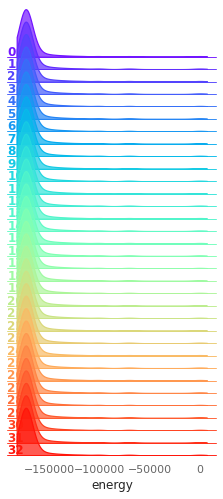

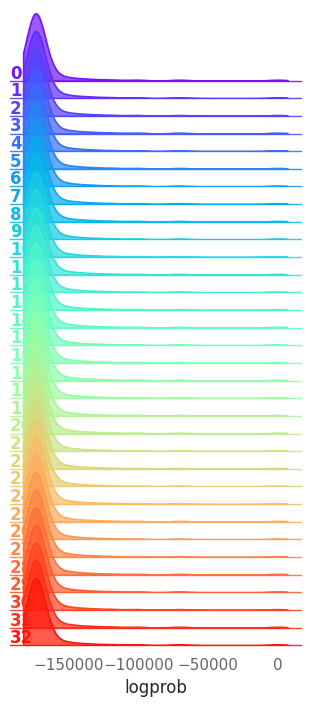

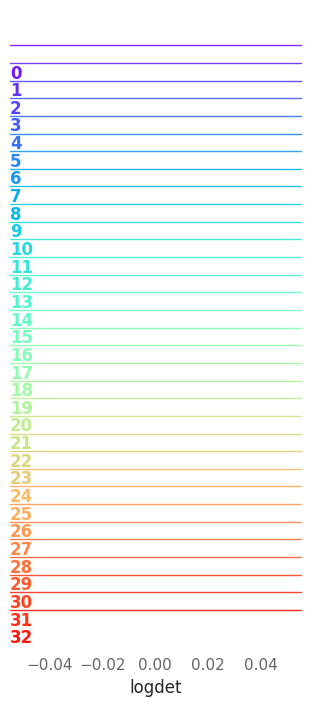

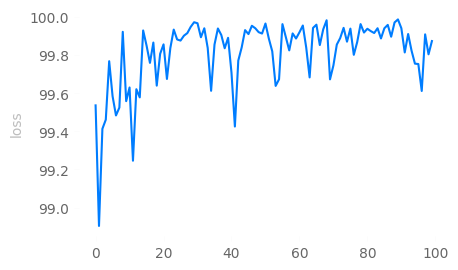

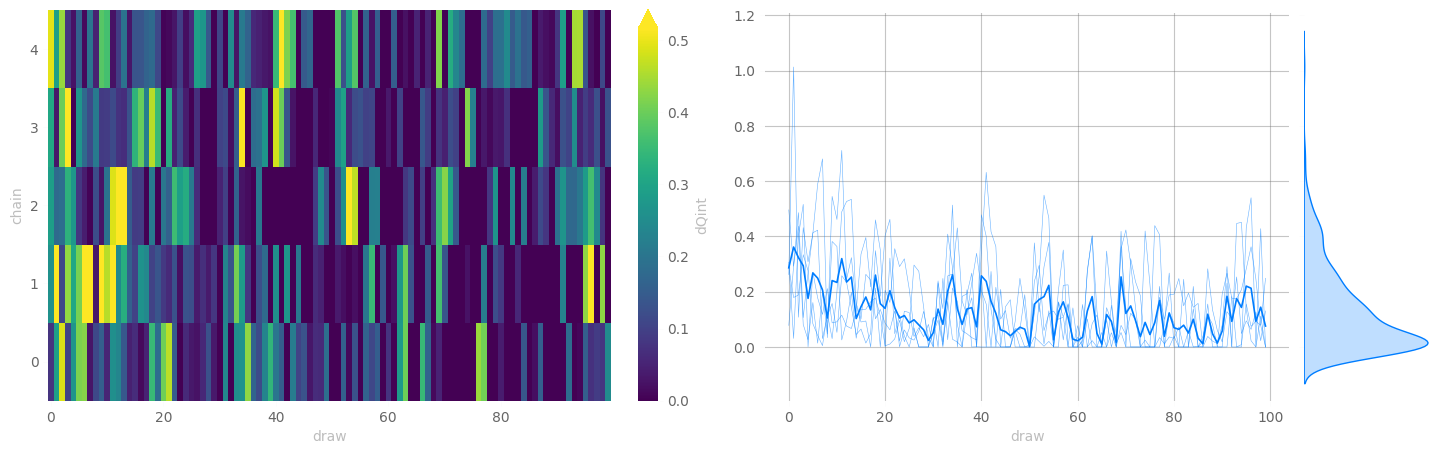

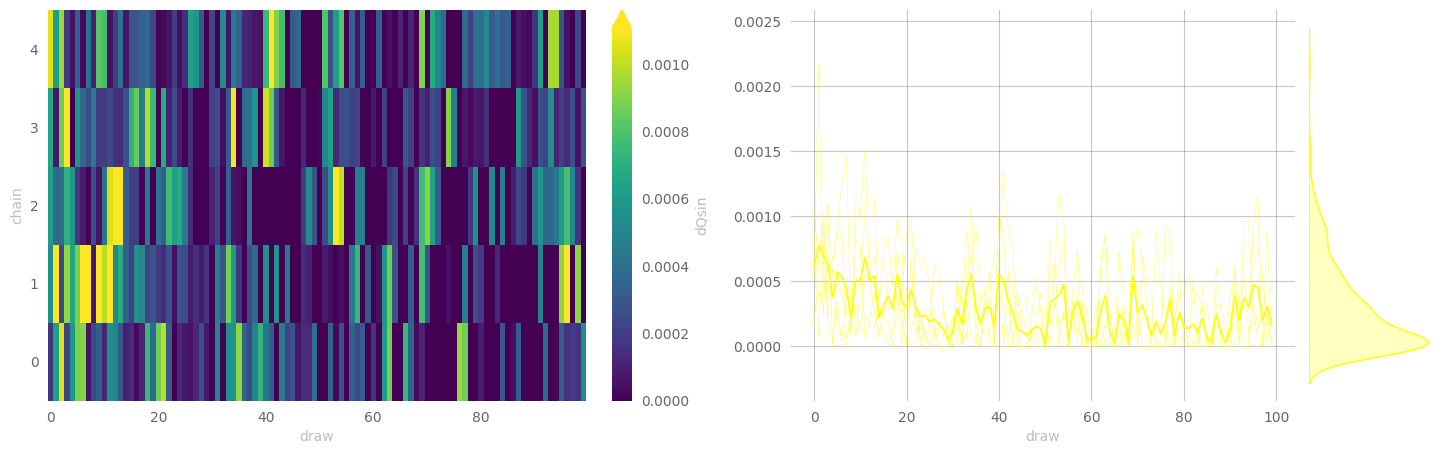

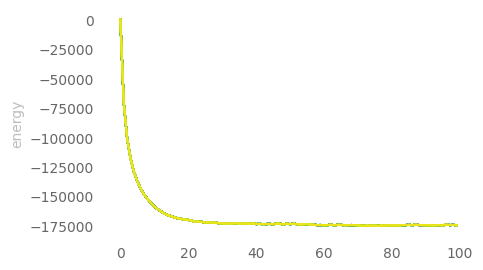

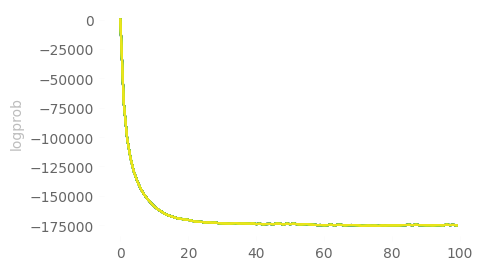

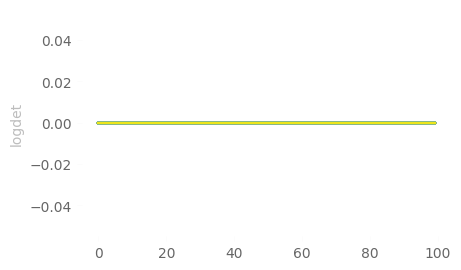

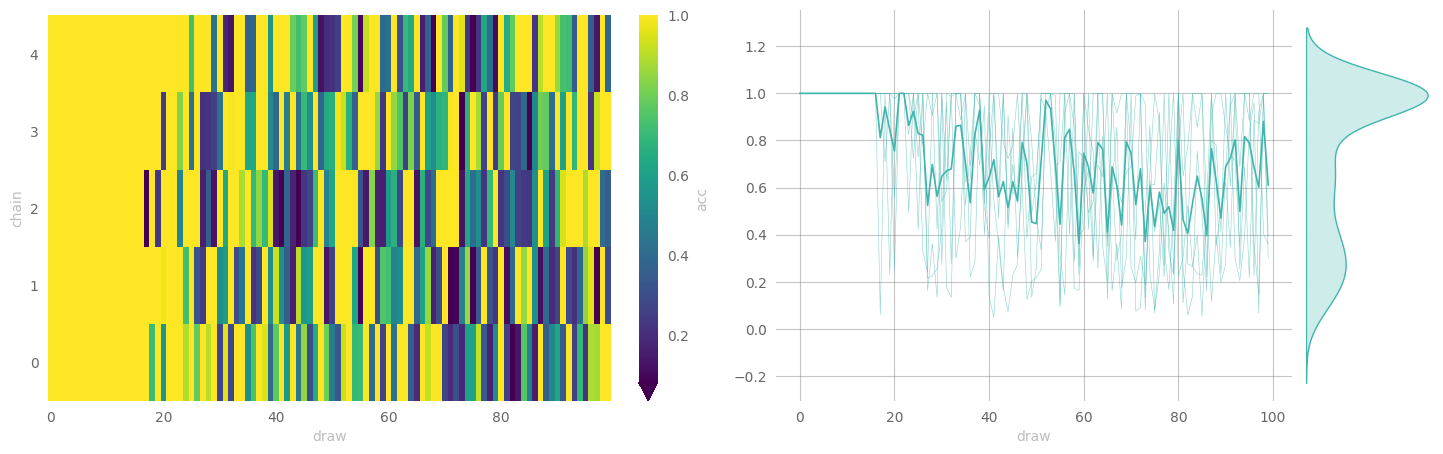

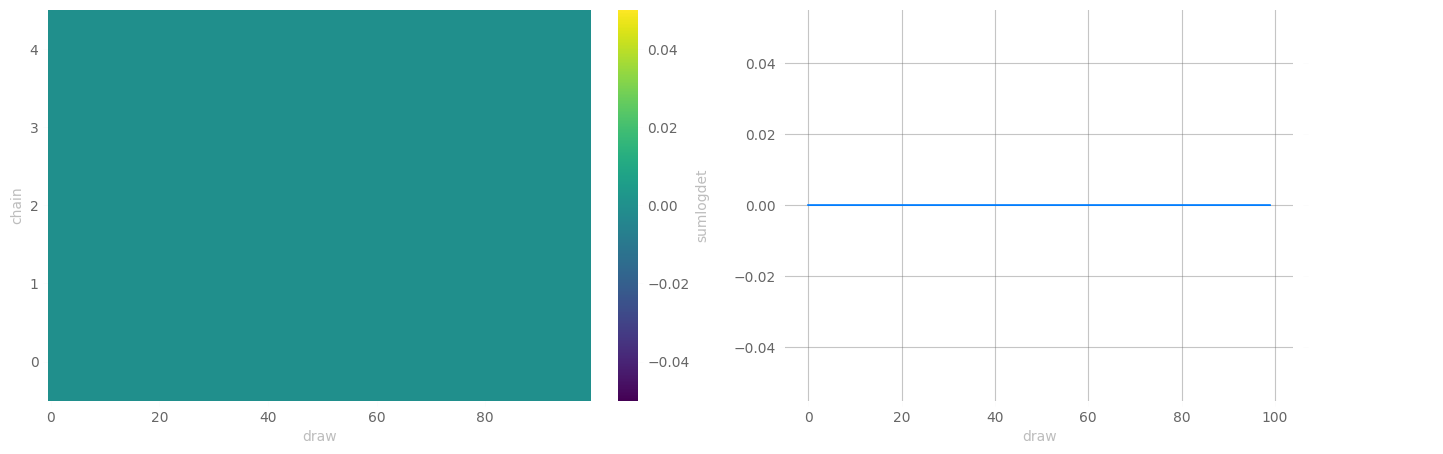

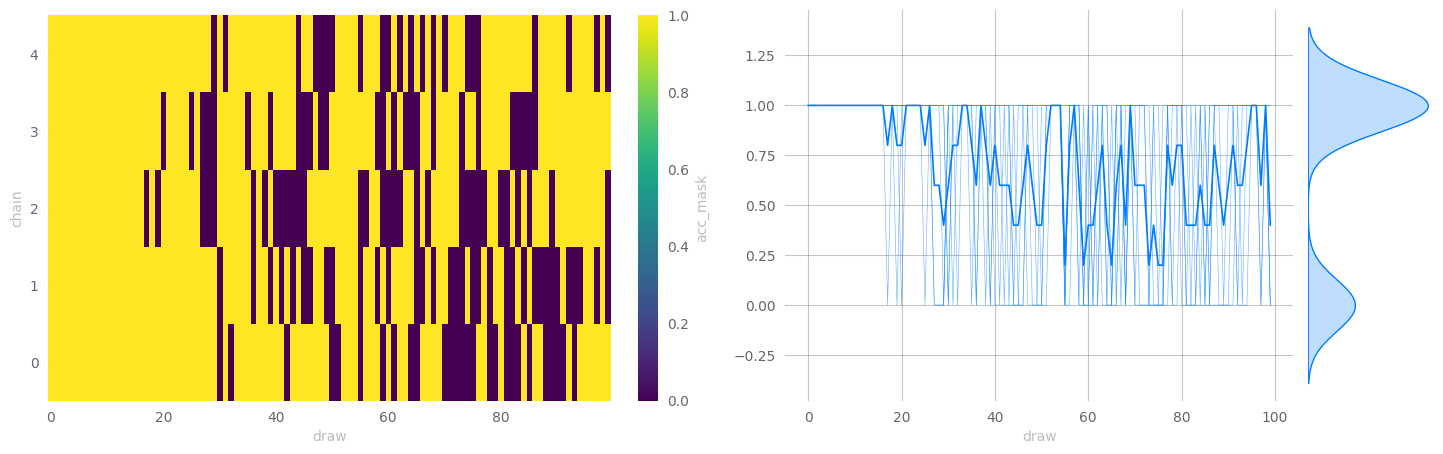

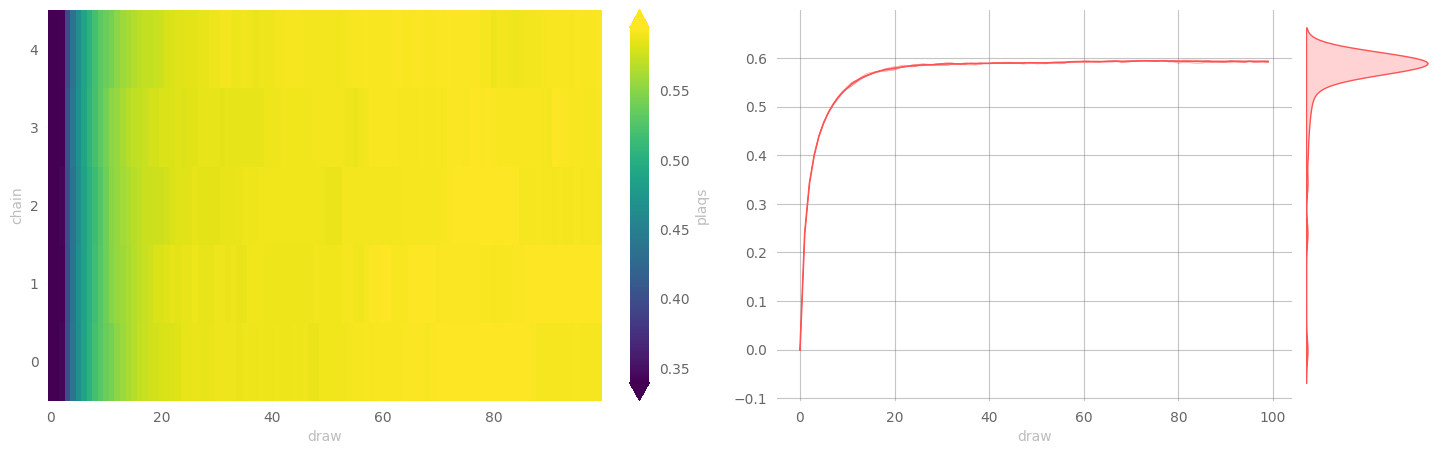

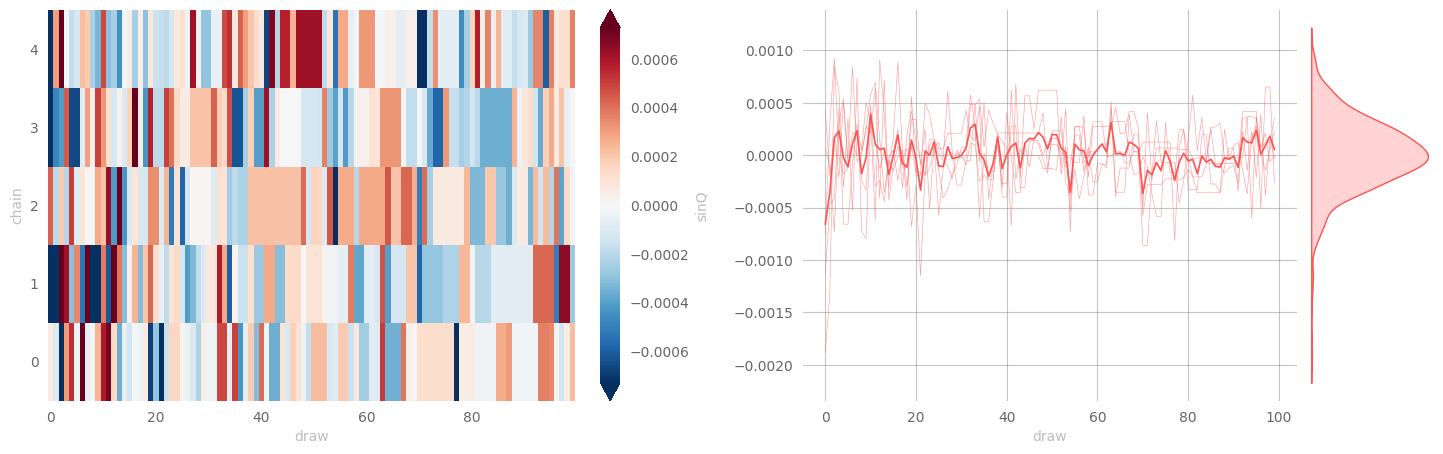

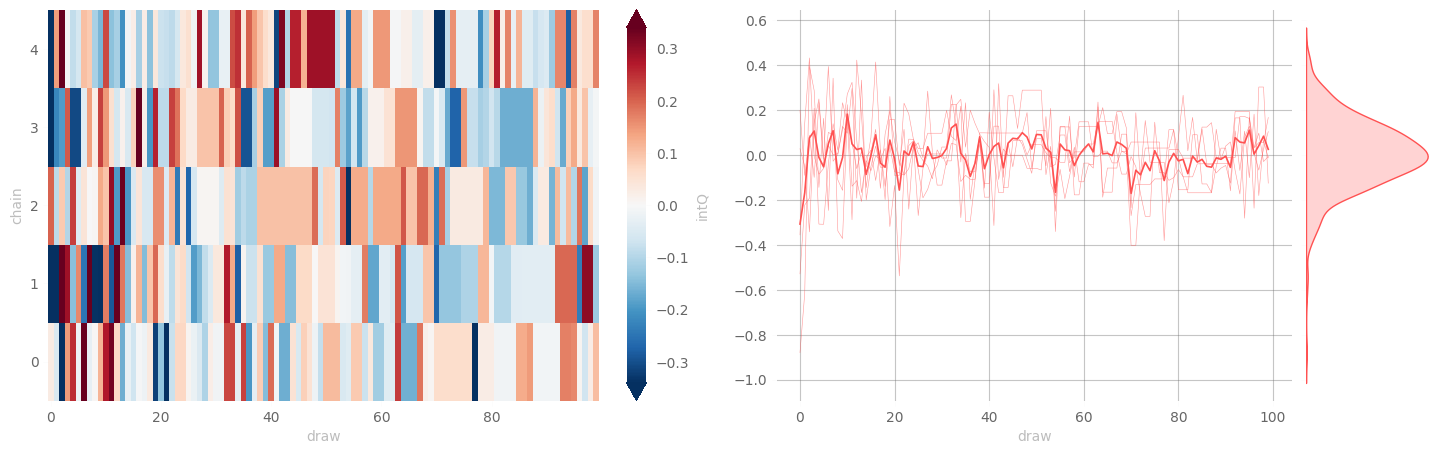

In [13]:
from l2hmc.common import plot_dataset
from l2hmc.utils.plot_helpers import set_plot_style
set_plot_style()
dataset_pt = ptExpSU3.trainer.histories['hmc'].get_dataset()
plot_dataset(dataset_pt)

In [14]:
x0tf = tf.constant(grab_tensor(ptExpSU3.trainer.lattice.random()))
x0tf.shape

outputs_tf = tfExpSU3.trainer.eval(
    beta=tf.constant(6.0),
    x=x0tf,
    eval_steps=100,
    job_type='hmc',
    eps=0.03125,
    nleapfrog=32,
)

07:46:11 WARNING  x.shape (original): (5, 4, 8, 8, 8, 16, 3, 3)                                           ]8;id=857047;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=924390;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#524\524]8;;\

         WARNING  x[:nchains].shape: (5, 4, 8, 8, 8, 16, 3, 3)                                            ]8;id=178227;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=769178;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#530\530]8;;\

07:46:15 INFO     step=0.00, beta=6.00, dt=3.62, hmc_step=0.00, loss=98.29, dQint=0.60, dQsin=0.00,       ]8;id=819004;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=854318;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=182.53, logprob=182.53, logdet=0.00+0.00j, acc=1.00, sumlogdet=0.00+0.00j,                     
                  acc_mask=1.00, plaqs=-0.00, sinQ=-0.00, intQ=-0.19                                                    

07:46:32 INFO     step=5.00, beta=6.00, dt=3.54, hmc_step=5.00, loss=99.51, dQint=0.28, dQsin=0.00,       ]8;id=459142;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=310041;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-137728.53, logprob=-137728.53, logdet=0.00+0.00j, acc=1.00,                                   
                  sumlogdet=0.00+0.00j, acc_mask=1.00, plaqs=0.47, sinQ=-0.00, intQ=-0.10                               

07:46:50 INFO     step=10.00, beta=6.00, dt=3.74, hmc_step=10.00, loss=99.61, dQint=0.23, dQsin=0.00,     ]8;id=288401;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=129894;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-159005.07, logprob=-159005.07, logdet=0.00+0.00j, acc=1.00,                                   
                  sumlogdet=0.00+0.00j, acc_mask=1.00, plaqs=0.54, sinQ=-0.00, intQ=-0.09                               

07:47:07 INFO     step=15.00, beta=6.00, dt=3.42, hmc_step=15.00, loss=99.81, dQint=0.15, dQsin=0.00,     ]8;id=815444;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=194638;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-167212.01, logprob=-167212.01, logdet=0.00+0.00j, acc=1.00,                                   
                  sumlogdet=0.00+0.00j, acc_mask=1.00, plaqs=0.57, sinQ=-0.00, intQ=-0.02                               

07:47:24 INFO     step=20.00, beta=6.00, dt=3.43, hmc_step=20.00, loss=99.76, dQint=0.14, dQsin=0.00,     ]8;id=436548;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=457241;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-170811.18, logprob=-170811.18, logdet=0.00+0.00j, acc=0.78,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.58, sinQ=-0.00, intQ=-0.07                               

07:47:42 INFO     step=25.00, beta=6.00, dt=3.73, hmc_step=25.00, loss=99.91, dQint=0.04, dQsin=0.00,     ]8;id=806420;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=125270;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-171985.27, logprob=-171985.27, logdet=0.00+0.00j, acc=0.81,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.58, sinQ=-0.00, intQ=-0.09                               

07:47:59 INFO     step=30.00, beta=6.00, dt=3.79, hmc_step=30.00, loss=99.91, dQint=0.12, dQsin=0.00,     ]8;id=984713;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=555534;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-172881.98, logprob=-172881.98, logdet=0.00+0.00j, acc=0.95,                                   
                  sumlogdet=0.00+0.00j, acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.06                                 

07:48:16 INFO     step=35.00, beta=6.00, dt=3.41, hmc_step=35.00, loss=99.80, dQint=0.15, dQsin=0.00,     ]8;id=108100;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=869711;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-173809.97, logprob=-173809.97, logdet=0.00+0.00j, acc=0.67,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.03                                 

07:48:34 INFO     step=40.00, beta=6.00, dt=3.41, hmc_step=40.00, loss=99.81, dQint=0.11, dQsin=0.00,     ]8;id=881401;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=508770;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-173887.74, logprob=-173887.74, logdet=0.00+0.00j, acc=0.61,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.03                               

07:48:51 INFO     step=45.00, beta=6.00, dt=3.44, hmc_step=45.00, loss=99.76, dQint=0.10, dQsin=0.00,     ]8;id=395124;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=857456;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174196.25, logprob=-174196.25, logdet=0.00+0.00j, acc=0.61,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.03                                 

07:49:08 INFO     step=50.00, beta=6.00, dt=3.41, hmc_step=50.00, loss=99.78, dQint=0.10, dQsin=0.00,     ]8;id=856439;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=688276;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174649.36, logprob=-174649.36, logdet=0.00+0.00j, acc=0.64,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.06                                 

07:49:26 INFO     step=55.00, beta=6.00, dt=3.45, hmc_step=55.00, loss=99.82, dQint=0.22, dQsin=0.00,     ]8;id=267884;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=672182;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174455.57, logprob=-174455.57, logdet=0.00+0.00j, acc=0.69,                                   
                  sumlogdet=0.00+0.00j, acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.06                               

07:49:43 INFO     step=60.00, beta=6.00, dt=3.55, hmc_step=60.00, loss=99.96, dQint=0.00, dQsin=0.00,     ]8;id=200711;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=362124;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174459.18, logprob=-174459.18, logdet=0.00+0.00j, acc=0.30,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.00, plaqs=0.59, sinQ=-0.00, intQ=-0.05                               

07:50:00 INFO     step=65.00, beta=6.00, dt=3.71, hmc_step=65.00, loss=99.93, dQint=0.05, dQsin=0.00,     ]8;id=113411;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=736791;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174629.59, logprob=-174629.59, logdet=0.00+0.00j, acc=0.61,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.07                                 

07:50:18 INFO     step=70.00, beta=6.00, dt=3.41, hmc_step=70.00, loss=99.77, dQint=0.21, dQsin=0.00,     ]8;id=734143;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=849284;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174719.31, logprob=-174719.31, logdet=0.00+0.00j, acc=0.62,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.80, plaqs=0.59, sinQ=-0.00, intQ=-0.16                               

07:50:35 INFO     step=75.00, beta=6.00, dt=3.41, hmc_step=75.00, loss=99.79, dQint=0.21, dQsin=0.00,     ]8;id=164804;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=608608;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174466.35, logprob=-174466.35, logdet=0.00+0.00j, acc=0.61,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.04                                 

07:50:53 INFO     step=80.00, beta=6.00, dt=3.57, hmc_step=80.00, loss=99.91, dQint=0.05, dQsin=0.00,     ]8;id=952097;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=988809;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174956.02, logprob=-174956.02, logdet=0.00+0.00j, acc=0.66,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.07                               

07:51:10 INFO     step=85.00, beta=6.00, dt=3.45, hmc_step=85.00, loss=99.71, dQint=0.16, dQsin=0.00,     ]8;id=282413;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=162368;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174661.91, logprob=-174661.91, logdet=0.00+0.00j, acc=0.72,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.06                               

07:51:30 INFO     step=90.00, beta=6.00, dt=4.72, hmc_step=90.00, loss=99.89, dQint=0.09, dQsin=0.00,     ]8;id=889115;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=881306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174880.67, logprob=-174880.67, logdet=0.00+0.00j, acc=0.70,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.06                                 

07:51:55 INFO     step=95.00, beta=6.00, dt=4.95, hmc_step=95.00, loss=99.77, dQint=0.19, dQsin=0.00,     ]8;id=755108;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=339203;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175234.34, logprob=-175234.34, logdet=0.00+0.00j, acc=0.79,                                   
                  sumlogdet=0.00+0.00j, acc_mask=0.80, plaqs=0.59, sinQ=-0.00, intQ=-0.14                               

07:54:58 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=832110;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=825218;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /ridgeplots/energy_ridgeplot.svg                                                                      

07:55:03 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=468368;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=755692;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /ridgeplots/logprob_ridgeplot.svg                                                                     

07:55:09 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=74211;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=82304;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /ridgeplots/logdet_ridgeplot.svg                                                                      

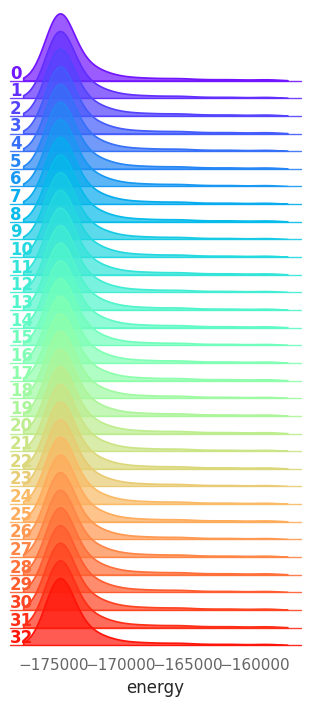

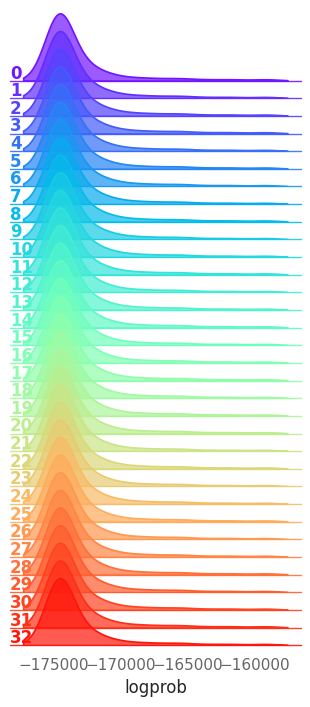

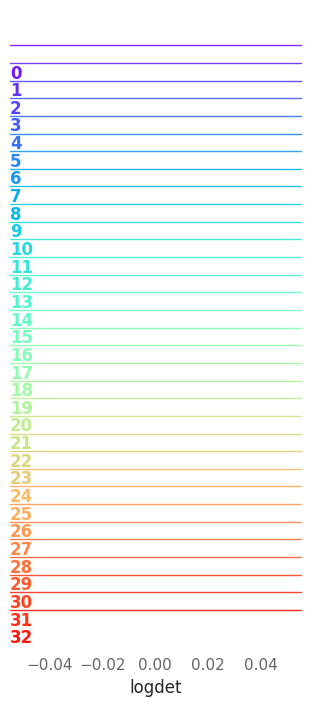

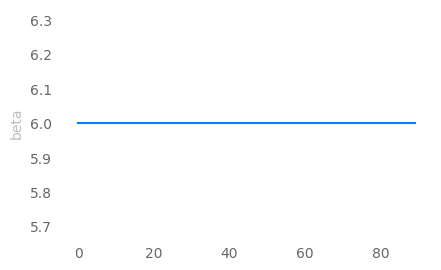

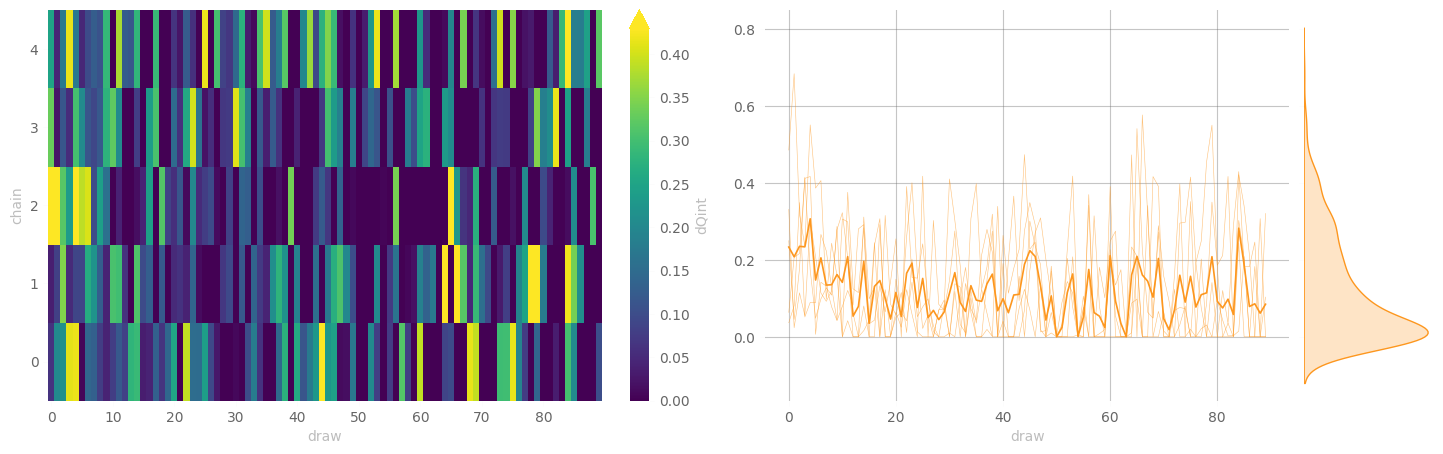

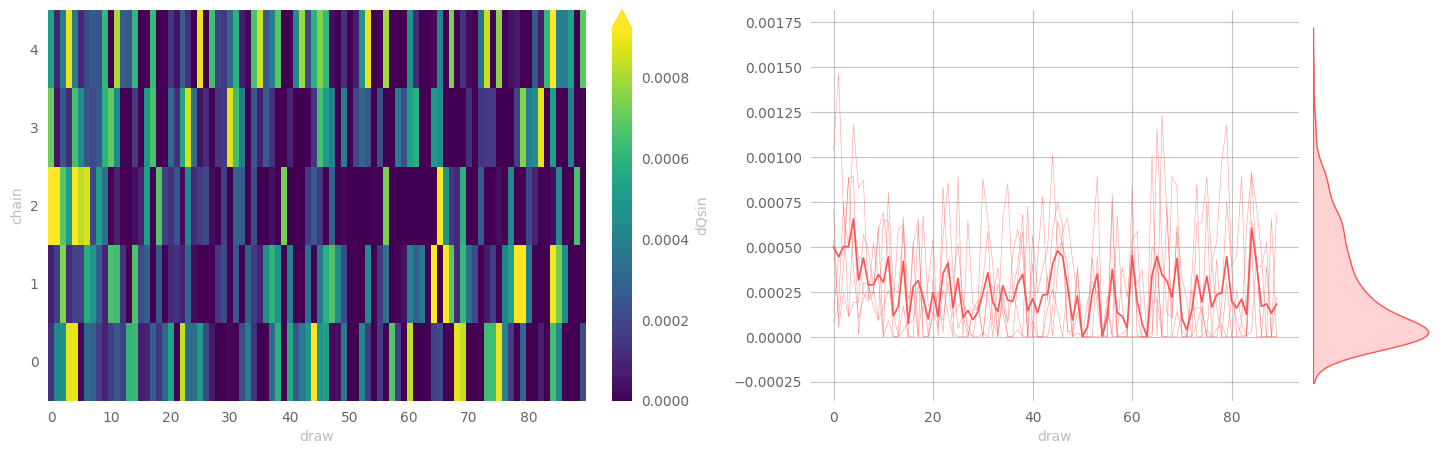

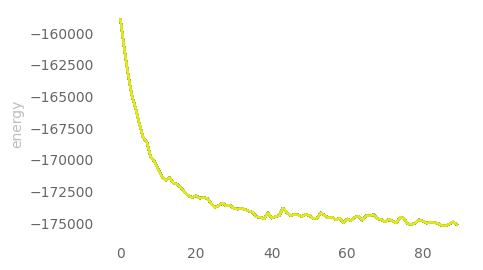

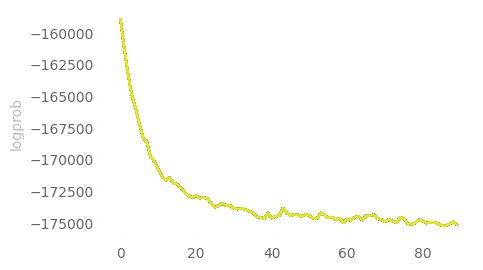

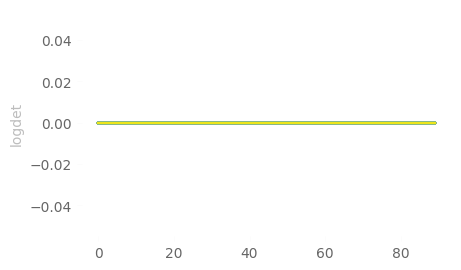

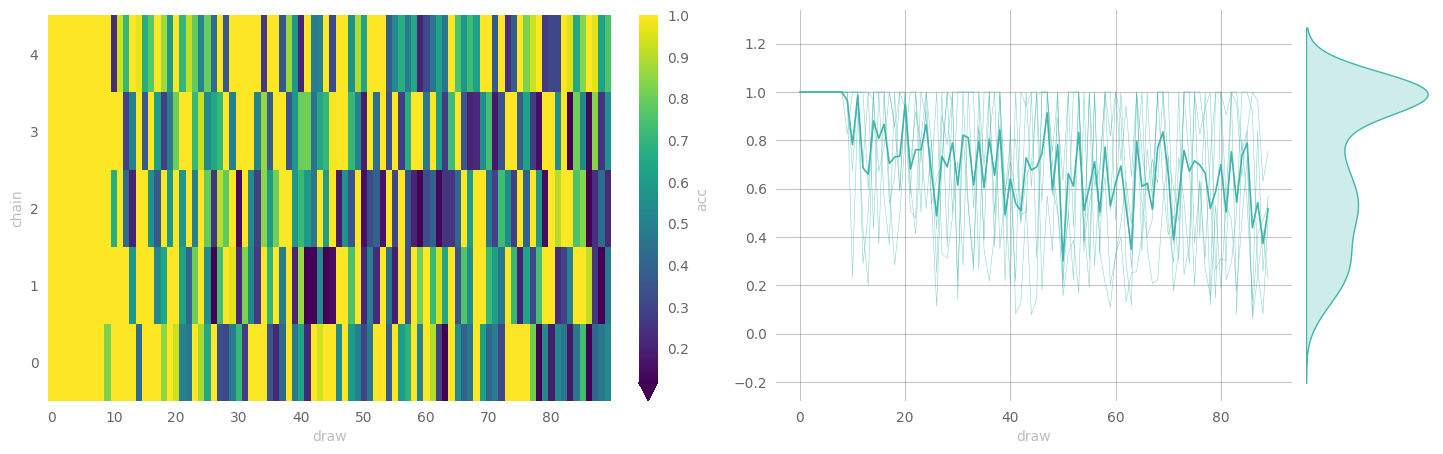

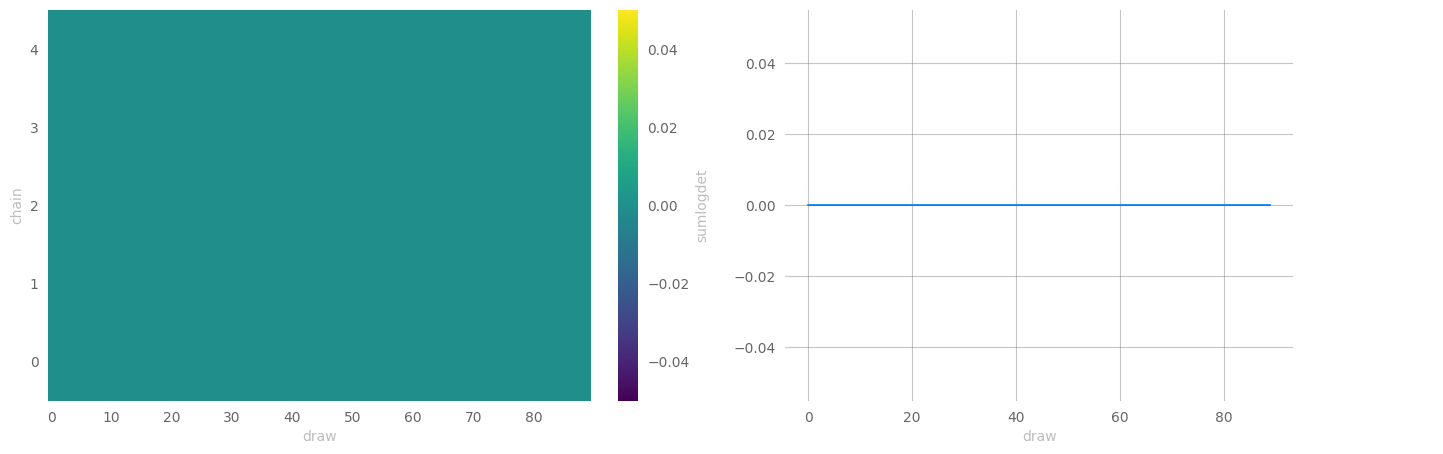

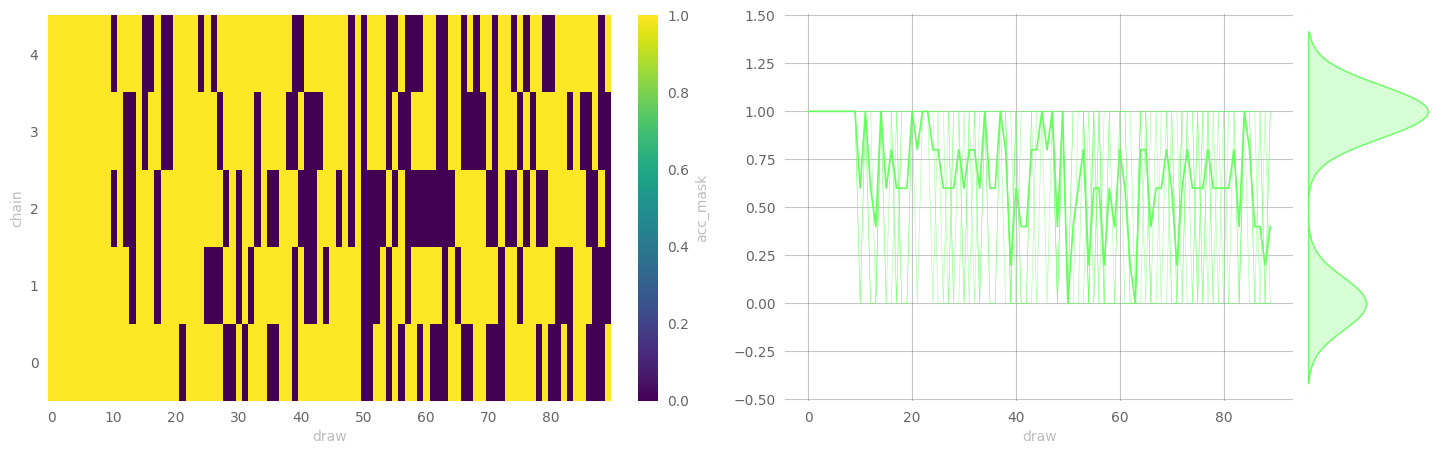

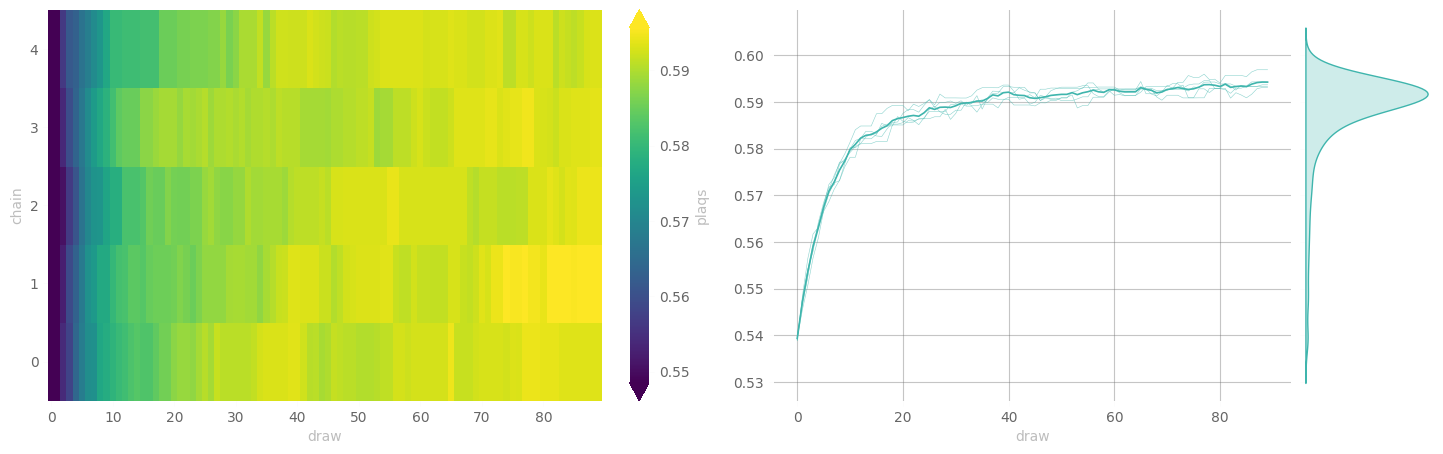

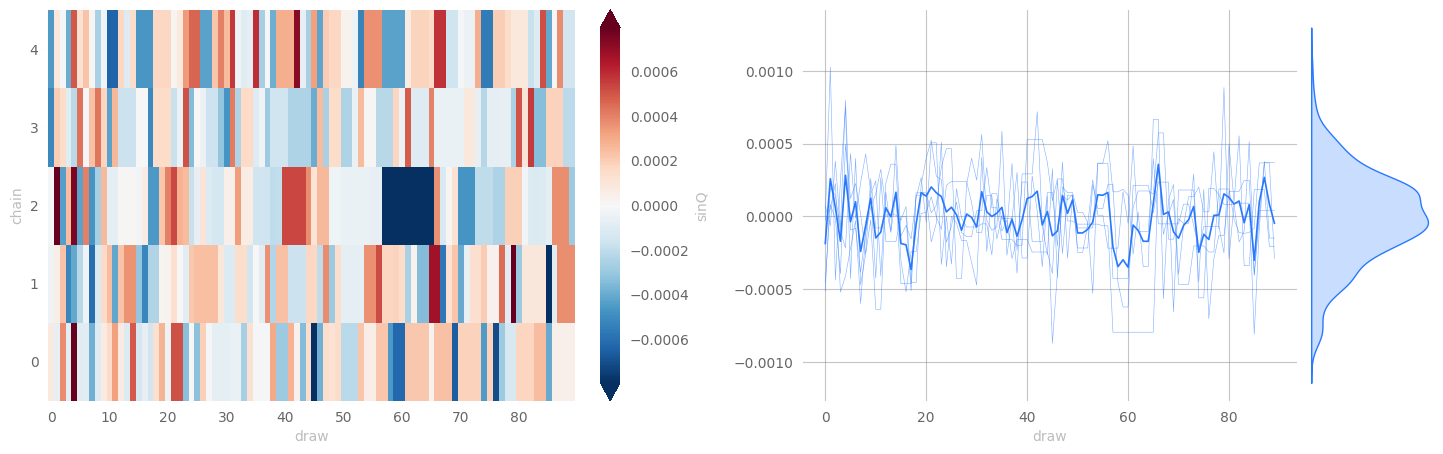

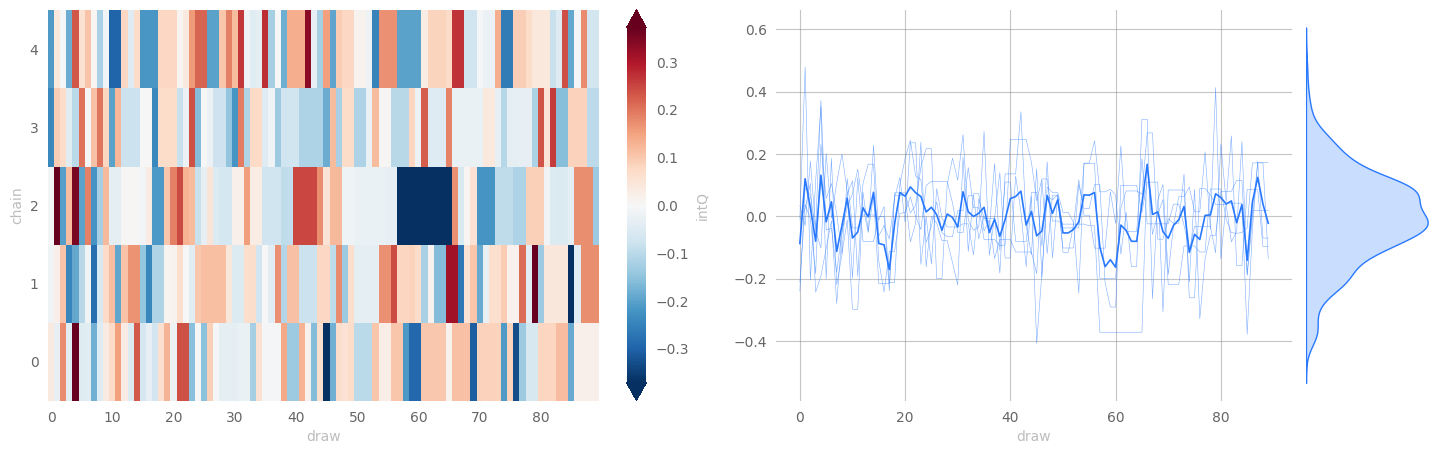

In [15]:
from l2hmc.common import plot_dataset
from l2hmc.utils.plot_helpers import set_plot_style
set_plot_style()
dataset_tf = tfExpSU3.trainer.histories['hmc'].get_dataset(therm_frac=0.1)
plot_dataset(dataset_tf)

# Explicitly compare `nthmc` and `l2hmc:

In [14]:
x0tf = tfExpSU3.trainer.lattice.random()
outputs_tf = tfExpSU3.train(x=x0tf, nera=1, nepoch=10, beta=0.7796)

─────────────────────────────────────────────── ERA: 0 / 1, BETA: 0.780 ────────────────────────────────────────────────

InvalidArgumentError: Exception encountered when calling layer "dynamics" (type Dynamics).

Input for dynamic binary or n-ary op lowering was of a rank greater than 5 [Op:Mul]

Call arguments received by layer "dynamics" (type Dynamics):
  • inputs=('tf.Tensor(shape=(5, 4, 8, 8, 8, 16, 3, 3), dtype=complex128)', 'tf.Tensor(shape=(), dtype=float64)')
  • training=True

In [15]:
from l2hmc.nthmc.su3_4d import nthmc, ftr, evolve, gauge
from l2hmc.nthmc.su3_4d.gauge import C1DBW2

In [16]:
from l2hmc.nthmc.su3_4d.gauge import SU3d4

conf = nthmc.Conf(
    nbatch=2,
    nepoch=2,
    nstepEpoch=8,
    trajLength=0.0625,
    stepPerTraj=2
)
#nthmc.setup(conf)
action = SU3d4(
    tf.random.Generator.from_seed(1234),
    nbatch=2,
    transform=ftr.Ident(),
    beta=0.7796,
    beta0=0.7796,
    c1=0.0,
    size=[8, 8, 8, 16]
)

SU3d4 init with beta 0.7796 coeff (0.7796, 0) shape (2, 4, 8, 8, 8, 16, 3, 3)


In [17]:
from l2hmc.common import check_diff, grab_tensor

x0 = action.random()
v0 = action.randomMom()
x0tf = x0
x0pt = torch.tensor(grab_tensor(x0tf))

check_diff(
    x0tf,
    x0pt,
)

18:36:57 INFO       min(diff): 0j                                                                          ]8;id=248313;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=32310;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 0j                                                                                       
                    sum(diff): 0j                                                                                       
                    sum(diff ** 2): 0j                                                                                  
                    mean(diff): 0j                                                                                      
                    std(diff): 0.0                                                                                      
                    np.allclose: True                                                                                   

## Check kinetic energy:

In [15]:
lattice_tf = tfExpSU3.trainer.lattice
lattice_pt = ptExpSU3.trainer.lattice

v0tf = v0
v0pt = torch.tensor(grab_tensor(v0tf))

ke_nt = action.momEnergy(v0)
ke_tf = lattice_tf.kinetic_energy(v0tf)
ke_pt = lattice_pt.kinetic_energy(v0pt)

check_diff(
    ke_nt,
    ke_tf
)
check_diff(
    ke_nt,
    ke_pt
)

17:44:17 INFO       min(diff): 0.0                                                                         ]8;id=371862;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=248313;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 4.973799150320701e-14                                                                    
                    sum(diff): 4.973799150320701e-14                                                                    
                    sum(diff ** 2): 2.473867798773093e-27                                                               

         INFO       min(diff): -3.410605131648481e-13                                                      ]8;id=18274;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=32310;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): -2.2737367544323206e-13                                                                  
                    sum(diff): -5.684341886080801e-13                                                                   
                    sum(diff ** 2): 1.6802106192483375e-25                                                              

## Check plaquettes:

In [16]:
plaqs_nt = action.plaquette(x0tf)
plaqs_tf = lattice_tf.plaqs(x=x0tf)
plaqs_pt = lattice_pt.plaqs(x=x0pt)

check_diff(
    plaqs_nt,
    plaqs_tf,
)
check_diff(
    plaqs_nt,
    plaqs_pt,
)

17:44:23 INFO       min(diff): 0.0                                                                         ]8;id=827088;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=16609;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 0.0                                                                                      
                    sum(diff): 0.0                                                                                      
                    sum(diff ** 2): 0.0                                                                                 

         INFO       min(diff): 0.0                                                                         ]8;id=362900;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=679808;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 5.963111948670274e-19                                                                    
                    sum(diff): 5.963111948670274e-19                                                                    
                    sum(diff ** 2): 3.5558704112374197e-37                                                              

## Check action:

In [17]:
beta_tf = action.beta
beta_pt = torch.tensor(beta_tf.numpy()).cuda()
x0pt = x0pt.cuda()

act_nt, _, _ = action.action(x0tf)
act_tf = lattice_tf.action(x0tf, beta=beta_tf)
act_pt = lattice_pt.action(x0pt, beta=beta_pt)

check_diff(act_nt, act_tf)
check_diff(act_nt, act_pt)

17:44:30 INFO       min(diff): 0.0                                                                         ]8;id=653557;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=507768;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 0.0                                                                                      
                    sum(diff): 0.0                                                                                      
                    sum(diff ** 2): 0.0                                                                                 

         INFO       min(diff): -1.7763568394002505e-14                                                     ]8;id=645729;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=486065;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 7.105427357601002e-15                                                                    
                    sum(diff): -1.0658141036401503e-14                                                                  
                    sum(diff ** 2): 3.660314600225495e-28                                                               

## Check force:

In [18]:
force_nt, _, _ = action.derivAction(x0tf)
force_nt_ = action.derivActionPlaq(x0tf)
force_tf = lattice_tf.grad_action(x0tf, beta=beta_tf)
force_pt = lattice_pt.grad_action(x0pt, beta=beta_pt)

check_diff(force_nt, force_nt_, 'action.derivAction vs. action.derivActionPlaq')
check_diff(force_nt, force_tf, 'action.derivAction vs. l2hmc.grad_action (tf)')
check_diff(force_nt, force_pt, 'action.derivAction vs. l2hmc.grad_action (pt)')

17:44:42 INFO     'action.derivAction vs. action.derivActionPlaq''                                         ]8;id=155770;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=95721;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-0.24146854339908264-0.0005869703593829288j)                                            
                    max(diff): (0.24146854339908264-0.0005869703593829288j)                                             
                    sum(diff): (-1.9984014443252818e-15-3.373028902926676j)                                             
                    sum(diff ** 2): (-706.8514963331486-1.214306433183765e-16j)                                         
                    mean(diff): (-3.3881317890172014e-21-5.718704059052659e-06j)                                        
                    std(diff): 0.06929565632963022                                                                      
                    np.allclose: False                                                                                  

         INFO     'action.derivAction vs. l2hmc.grad_action (tf)''                                         ]8;id=191984;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=748064;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-2.220446049250313e-16-2.7755575615628914e-17j)                                         
                    max(diff): (2.220446049250313e-16+5.551115123125783e-17j)                                           
                    sum(diff): -3.1889421658881645e-14j                                                                 
                    sum(diff ** 2): (-2.5780428314812564e-28+0j)                                                        
                    mean(diff): -5.406599537977709e-20j                                                                 
                    std(diff): 3.899998282205058e-17                                                                    
                    np.allclose: True                                                                                   

         INFO     'action.derivAction vs. l2hmc.grad_action (pt)''                                         ]8;id=119970;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=886412;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-2.220446049250313e-16-5.551115123125783e-17j)                                          
                    max(diff): (2.220446049250313e-16+2.7755575615628914e-17j)                                          
                    sum(diff): -6.760434226316114e-15j                                                                  
                    sum(diff ** 2): (-2.859534213731619e-28+0j)                                                         
                    mean(diff): -1.1461782203362552e-20j                                                                
                    std(diff): 3.963932548777433e-17                                                                    
                    np.allclose: True                                                                                   

## Check MCMC:

In [19]:
mdLF = evolve.LeapFrog(conf, action)
x, v, _, _, _, _ = mdLF(x0tf, v0tf)

LeapFrog init with dt 0.03125 step/traj 2


In [21]:
from typing import Any
from l2hmc.configs import State

def leapfrog_hmc(
        state: State,
        lattice: Any,
        tlen: int | float,
        nleapfrog: int
):
    dt = float(tlen / nleapfrog)
    if isinstance(state.x, tf.Tensor):
        dt = tf.cast(dt, state.x.dtype)
    elif isinstance(state.x, torch.Tensor):
        dt = torch.tensor(dt, dtype=state.x.dtype)
        
    x = lattice.g.update_gauge(state.x, 0.5 * dt * state.v)
    force = lattice.grad_action(x, state.beta)
    v = state.v - dt * force
    for _ in range(1, nleapfrog):
        x = lattice.g.update_gauge(x, dt * v)
        force = lattice.grad_action(x, state.beta)
        v = v - dt * force
        
    x = lattice.g.update_gauge(x, 0.5 * dt * v)
    return x, -v

In [20]:
from l2hmc.configs import State
state0_pt = State(x=x0pt.cuda(), v=v0pt.cuda(), beta=beta_pt.cuda())
state0_tf = State(x=x0tf, v=v0tf, beta=tf.constant(beta_tf))

In [23]:
x1tf, v1tf = leapfrog_hmc(state0_tf, lattice=lattice_tf, tlen=0.0625, nleapfrog=2)
x1pt, v1pt = leapfrog_hmc(state0_pt, lattice=lattice_pt, tlen=0.0625, nleapfrog=2)

In [22]:
dynamics_tf = tfExpSU3.trainer.dynamics

dynamics_pt = ptExpSU3.trainer.dynamics

force_nt, _, _ = action.derivAction(x0tf)
force_tf = dynamics_tf.grad_potential(x0tf, beta_tf)
force_pt = dynamics_pt.grad_potential(x0pt, beta_pt)

check_diff(force_nt, force_tf, 'force: nthmc vs. l2hmc (TF)')
check_diff(force_nt, force_pt, 'force: nthmc vs. l2hmc (PT)')
check_diff(force_pt, force_tf, 'force: l2hmc TF vs PT')

17:45:29 INFO     'force: nthmc vs. l2hmc (TF)''                                                           ]8;id=15328;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=527521;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-2.220446049250313e-16-2.7755575615628914e-17j)                                         
                    max(diff): (2.220446049250313e-16+5.551115123125783e-17j)                                           
                    sum(diff): -3.1889421658881645e-14j                                                                 
                    sum(diff ** 2): (-2.5780428314812564e-28+0j)                                                        
                    mean(diff): -5.406599537977709e-20j                                                                 
                    std(diff): 3.899998282205058e-17                                                                    
                    np.allclose: True                                                                                   

         INFO     'force: nthmc vs. l2hmc (PT)''                                                           ]8;id=510395;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=923240;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-2.220446049250313e-16-5.551115123125783e-17j)                                          
                    max(diff): (2.220446049250313e-16+2.7755575615628914e-17j)                                          
                    sum(diff): -6.760434226316114e-15j                                                                  
                    sum(diff ** 2): (-2.859534213731619e-28+0j)                                                         
                    mean(diff): -1.1461782203362552e-20j                                                                
                    std(diff): 3.963932548777433e-17                                                                    
                    np.allclose: True                                                                                   

         INFO     'force: l2hmc TF vs PT''                                                                 ]8;id=261963;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=67698;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-2.220446049250313e-16+0j)                                                              
                    max(diff): (2.220446049250313e-16+1.3877787807814457e-17j)                                          
                    sum(diff): -2.512898743256553e-14j                                                                  
                    sum(diff ** 2): (-1.4700097515667664e-28+0j)                                                        
                    mean(diff): -4.260421317641454e-20j                                                                 
                    std(diff): 2.395056998162701e-17                                                                    
                    np.allclose: True                                                                                   

In [24]:
check_diff(x1tf, x, 'x1 (nthmc) vs. x1 (l2hmc) TF')
check_diff(v1tf, v, 'v1 (nthmc) vs. v1 (l2hmc) TF')

check_diff(x1pt, x, 'x1 (nthmc) vs. x1 (l2hmc) PT')
check_diff(v1pt, v, 'v1 (nthmc) vs. v1 (l2hmc) PT')

check_diff(x1tf, x1pt, 'x1 (l2hmc) TF vs PT')
check_diff(v1tf, v1pt, 'v1 (l2hmc) TF vs PT')

17:45:46 INFO     'x1 (nthmc) vs. x1 (l2hmc) TF''                                                          ]8;id=699668;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=567372;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-1.1102230246251565e-16-1.1102230246251565e-16j)                                        
                    max(diff): (1.1102230246251565e-16+5.551115123125783e-17j)                                          
                    sum(diff): (-8.128128161852266e-17-3.9278781236665866e-16j)                                         
                    sum(diff ** 2): (-9.035282174107627e-32+3.7489900271453117e-32j)                                    
                    mean(diff): (-1.3780599232741063e-22-6.659407083581859e-22j)                                        
                    std(diff): 2.758480863695675e-18                                                                    
                    np.allclose: True                                                                                   

         INFO     'v1 (nthmc) vs. v1 (l2hmc) TF''                                                          ]8;id=956631;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=488530;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-4.440892098500626e-16+0j)                                                              
                    max(diff): (4.440892098500626e-16+0j)                                                               
                    sum(diff): -1.703503874420087e-14j                                                                  
                    sum(diff ** 2): (-2.882352187610953e-29+0j)                                                         
                    mean(diff): -2.888156254103066e-20j                                                                 
                    std(diff): 1.389571090781775e-17                                                                    
                    np.allclose: True                                                                                   

         INFO     'x1 (nthmc) vs. x1 (l2hmc) PT''                                                          ]8;id=71900;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=630680;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-1.657766146578865e-10-4.8975046240684605e-11j)                                         
                    max(diff): (1.7409695907133482e-10+2.4733326497994312e-11j)                                         
                    sum(diff): (2.576369591386702e-09+6.839616575125641e-09j)                                           
                    sum(diff ** 2): (7.290794438188839e-20+5.986065178066968e-20j)                                      
                    mean(diff): (4.368031126889889e-15+1.1596029620913426e-14j)                                         
                    std(diff): 1.519983170137946e-11                                                                    
                    np.allclose: True                                                                                   

         INFO     'v1 (nthmc) vs. v1 (l2hmc) PT''                                                          ]8;id=707921;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=93248;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-2.4829305278473157e-12-1.1873280136853737e-12j)                                        
                    max(diff): (2.4829305278473157e-12-1.1873280136853737e-12j)                                         
                    sum(diff): -1.9166631216177565e-10j                                                                 
                    sum(diff ** 2): (-2.392780094553269e-20+0j)                                                         
                    mean(diff): -3.249550919626459e-16j                                                                 
                    std(diff): 4.0389275869556583e-13                                                                   
                    np.allclose: True                                                                                   

         INFO     'x1 (l2hmc) TF vs PT''                                                                   ]8;id=540063;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=607128;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-1.7409695907133482e-10-2.4733326497994312e-11j)                                        
                    max(diff): (1.657766146578865e-10+4.8975046240684605e-11j)                                          
                    sum(diff): (-2.5763696726679836e-09-6.839616967913453e-09j)                                         
                    sum(diff ** 2): (7.290789659004649e-20+5.986062194213588e-20j)                                      
                    mean(diff): (-4.368031264695881e-15-1.1596030286854134e-14j)                                        
                    std(diff): 1.5199831704319857e-11                                                                   
                    np.allclose: True                                                                                   

17:45:47 INFO     'v1 (l2hmc) TF vs PT''                                                                   ]8;id=48198;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=282680;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    min(diff): (-2.4829305278473157e-12+1.1873280136853737e-12j)                                        
                    max(diff): (2.4829305278473157e-12+1.1873280136853737e-12j)                                         
                    sum(diff): 1.9164927712303145e-10j                                                                  
                    sum(diff ** 2): (-2.3927804302115613e-20+0j)                                                        
                    mean(diff): 3.2492621040010486e-16j                                                                 
                    std(diff): 4.0389273675887285e-13                                                                   
                    np.allclose: True                                                                                   

In [45]:
clear_cache()

In [46]:
xpt = ptExpSU3.trainer.lattice.random()
xpt_ = torch.zeros_like(xpt)

clear_cache()

torch.cuda.set_per_process_memory_fraction(1.0)

metrics_pt = run_hmc(
    ptExpSU3.trainer,
    x=xpt,
    beta=6.0,
    eps=0.03125,
    nleapfrog=32,
    neval=1000,
)

17:56:22 INFO     step: 0, dt: 0.9714, energy=561.2084, logprob=561.2084, logdet=0.0000, acc=1.0000,   ]8;id=410455;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=772512;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  sumlogdet=0.0000, acc_mask=1.0000, plaqs=0.2390, sinQ=-0.0009, intQ=-0.4088,                          
                  action=-70491.6763, dsdx=0.0000-243.6541j                                                             

17:56:23 INFO     step: 1, dt: 0.9700, energy=-70521.6910, logprob=-70521.6910, logdet=0.0000,         ]8;id=340169;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=217180;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, plaqs=0.3417, sinQ=0.0001,                             
                  intQ=0.0588, action=-100758.9180, dsdx=0.0000+201.2530j                                               

17:56:25 INFO     step: 2, dt: 0.9547, energy=-100842.6400, logprob=-100842.6400, logdet=0.0000,       ]8;id=862807;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=707484;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0344, dH=30320.9489,                             
                  plaqs=0.4025, sinQ=0.0002, intQ=0.1011, action=-118706.1457, dsdx=0.0000-95.9394j                     

17:56:27 INFO     step: 3, dt: 0.9521, energy=-118802.4236, logprob=-118802.4236, logdet=0.0000,       ]8;id=399718;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=981874;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0378, dH=17959.7837,                             
                  plaqs=0.4417, sinQ=0.0002, intQ=0.1104, action=-130247.9118, dsdx=0.0000+11.1617j                     

17:56:28 INFO     step: 4, dt: 0.9501, energy=-130212.8721, logprob=-130212.8721, logdet=0.0000,       ]8;id=916755;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=959679;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0416, dH=11410.4485,                             
                  plaqs=0.4711, sinQ=0.0004, intQ=0.2042, action=-138919.0383, dsdx=0.0000+63.3792j                     

17:56:30 INFO     step: 5, dt: 0.9523, energy=-139090.5493, logprob=-139090.5493, logdet=0.0000,       ]8;id=293651;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=563596;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0458, dH=8877.6772,                              
                  plaqs=0.4926, sinQ=-0.0003, intQ=-0.1318, action=-145259.3518, dsdx=0.0000+16.7440j                   

17:56:31 INFO     step: 6, dt: 0.9669, energy=-145196.5174, logprob=-145196.5174, logdet=0.0000,       ]8;id=662537;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=965809;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0503, dH=6105.9681,                              
                  plaqs=0.5094, sinQ=0.0001, intQ=0.0400, action=-150216.6222, dsdx=0.0000-210.8505j                    

17:56:33 INFO     step: 7, dt: 0.9778, energy=-150165.5487, logprob=-150165.5487, logdet=0.0000,       ]8;id=319327;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=442537;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0554, dH=4969.0312,                              
                  plaqs=0.5249, sinQ=0.0001, intQ=0.0621, action=-154792.0679, dsdx=0.0000-304.7353j                    

17:56:35 INFO     step: 8, dt: 1.0065, energy=-154595.9384, logprob=-154595.9384, logdet=0.0000,       ]8;id=334446;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=718557;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0609, dH=4430.3898,                              
                  plaqs=0.5362, sinQ=0.0005, intQ=0.2179, action=-158119.1795, dsdx=0.0000-144.1349j                    

17:56:36 INFO     step: 9, dt: 1.1405, energy=-157938.1391, logprob=-157938.1391, logdet=0.0000,       ]8;id=605814;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=888048;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0670, dH=3342.2007,                              
                  plaqs=0.5467, sinQ=0.0002, intQ=0.0737, action=-161215.5987, dsdx=0.0000-49.4036j                     

17:56:39 INFO     step: 10, dt: 1.6840, energy=-161538.2721, logprob=-161538.2721, logdet=0.0000,      ]8;id=158772;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=879511;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0737, dH=3600.1330,                              
                  plaqs=0.5553, sinQ=0.0001, intQ=0.0635, action=-163760.4433, dsdx=0.0000+502.7804j                    

17:56:41 INFO     step: 11, dt: 2.2018, energy=-163652.6026, logprob=-163652.6026, logdet=0.0000,      ]8;id=558513;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=97380;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0811, dH=2114.3305,                              
                  plaqs=0.5618, sinQ=-0.0001, intQ=-0.0586, action=-165681.1922, dsdx=0.0000+209.3302j                  

17:56:46 INFO     step: 12, dt: 3.4341, energy=-165694.8747, logprob=-165694.8747, logdet=0.0000,      ]8;id=801472;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=272960;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0892, dH=2042.2720,                              
                  plaqs=0.5669, sinQ=-0.0002, intQ=-0.0800, action=-167181.2119, dsdx=0.0000-111.9819j                  

17:56:51 INFO     step: 13, dt: 5.0471, energy=-167129.3796, logprob=-167129.3796, logdet=0.0000,      ]8;id=291525;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=430186;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.0195, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0802, dH=1434.5049,                              
                  plaqs=0.5683, sinQ=-0.0001, intQ=-0.0282, action=-167603.6268, dsdx=0.0000+67.3200j                   

17:56:55 INFO     step: 14, dt: 3.2370, energy=-167643.5283, logprob=-167643.5283, logdet=0.0000,      ]8;id=419500;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=899494;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0883, dH=514.1488,                               
                  plaqs=0.5721, sinQ=0.0002, intQ=0.0939, action=-168719.1925, dsdx=0.0000-240.3180j                    

17:57:01 INFO     step: 15, dt: 4.8149, energy=-169019.2777, logprob=-169019.2777, logdet=0.0000,      ]8;id=592385;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=290185;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0971, dH=1375.7493,                              
                  plaqs=0.5750, sinQ=0.0000, intQ=0.0219, action=-169560.8596, dsdx=0.0000-430.8076j                    

17:57:08 INFO     step: 16, dt: 6.6727, energy=-169776.6256, logprob=-169776.6256, logdet=0.0000,      ]8;id=551341;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=119263;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.0000, sumlogdet=0.0000, acc_mask=0.0000, eps=0.0874, dH=757.3479,                               
                  plaqs=0.5750, sinQ=0.0000, intQ=0.0219, action=-169560.8596, dsdx=0.0000-430.8076j                    

17:57:13 INFO     step: 17, dt: 4.6057, energy=-168978.6665, logprob=-168978.6665, logdet=0.0000,      ]8;id=735742;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=393581;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.5002, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0786, dH=-797.9591,                              
                  plaqs=0.5760, sinQ=0.0005, intQ=0.2431, action=-169861.0448, dsdx=0.0000-22.5463j                     

17:57:17 INFO     step: 18, dt: 3.1344, energy=-170051.7725, logprob=-170051.7725, logdet=0.0000,      ]8;id=287546;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=224275;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0865, dH=1073.1060,                              
                  plaqs=0.5785, sinQ=-0.0004, intQ=-0.1680, action=-170618.7230, dsdx=0.0000-49.3643j                   

17:57:22 INFO     step: 19, dt: 4.4098, energy=-170451.0097, logprob=-170451.0097, logdet=0.0000,      ]8;id=311894;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=751028;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.0000, sumlogdet=0.0000, acc_mask=0.0000, eps=0.0779, dH=399.2372,                               
                  plaqs=0.5785, sinQ=-0.0004, intQ=-0.1680, action=-170618.7230, dsdx=0.0000-49.3643j                   

17:57:25 INFO     step: 20, dt: 2.7970, energy=-170551.2213, logprob=-170551.2213, logdet=0.0000,      ]8;id=877797;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=616048;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.1786, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0701, dH=100.2117,                               
                  plaqs=0.5797, sinQ=-0.0002, intQ=-0.1053, action=-170974.7002, dsdx=0.0000+27.7788j                   

17:57:27 INFO     step: 21, dt: 1.7649, energy=-170686.9095, logprob=-170686.9095, logdet=0.0000,      ]8;id=417688;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=55049;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.5418, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0631, dH=135.6881,                               
                  plaqs=0.5806, sinQ=-0.0002, intQ=-0.1126, action=-171218.8689, dsdx=0.0000+287.7578j                  

17:57:29 INFO     step: 22, dt: 1.2140, energy=-171264.9265, logprob=-171264.9265, logdet=0.0000,      ]8;id=366504;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=920052;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0694, dH=578.0170,                               
                  plaqs=0.5824, sinQ=0.0001, intQ=0.0304, action=-171744.3805, dsdx=0.0000+445.9295j                    

17:57:31 INFO     step: 23, dt: 1.6764, energy=-171684.4506, logprob=-171684.4506, logdet=0.0000,      ]8;id=875047;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=461955;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.5062, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0624, dH=419.5242,                               
                  plaqs=0.5834, sinQ=-0.0000, intQ=-0.0086, action=-172041.1313, dsdx=0.0000+36.4547j                   

17:57:33 INFO     step: 24, dt: 1.1882, energy=-171642.9828, logprob=-171642.9828, logdet=0.0000,      ]8;id=243790;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=814625;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.4775, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0562, dH=-41.4679,                               
                  plaqs=0.5842, sinQ=-0.0002, intQ=-0.0909, action=-172296.0389, dsdx=0.0000-126.8057j                  

17:57:35 INFO     step: 25, dt: 1.0130, energy=-172568.3045, logprob=-172568.3045, logdet=0.0000,      ]8;id=514327;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=173351;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0618, dH=925.3218,                               
                  plaqs=0.5864, sinQ=-0.0003, intQ=-0.1321, action=-172950.2777, dsdx=0.0000-46.5568j                   

17:57:36 INFO     step: 26, dt: 1.1620, energy=-173209.8322, logprob=-173209.8322, logdet=0.0000,      ]8;id=399026;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=322874;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.0075, sumlogdet=0.0000, acc_mask=0.0000, eps=0.0556, dH=641.5277,                               
                  plaqs=0.5864, sinQ=-0.0003, intQ=-0.1321, action=-172950.2777, dsdx=0.0000-46.5568j                   

17:57:38 INFO     step: 27, dt: 1.0117, energy=-173313.6761, logprob=-173313.6761, logdet=0.0000,      ]8;id=2567;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=76888;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.5040, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0501, dH=103.8439,                               
                  plaqs=0.5871, sinQ=-0.0002, intQ=-0.0926, action=-173144.0147, dsdx=0.0000-349.9274j                  

17:57:39 INFO     step: 28, dt: 0.9798, energy=-173303.2486, logprob=-173303.2486, logdet=0.0000,      ]8;id=503533;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=414177;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.1186, sumlogdet=0.0000, acc_mask=0.0000, eps=0.0451, dH=-10.4275,                               
                  plaqs=0.5871, sinQ=-0.0002, intQ=-0.0926, action=-173144.0147, dsdx=0.0000-349.9274j                  

17:57:41 INFO     step: 29, dt: 0.9626, energy=-173035.2989, logprob=-173035.2989, logdet=0.0000,      ]8;id=312917;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=449745;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.7011, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0406, dH=-267.9497,                              
                  plaqs=0.5874, sinQ=-0.0001, intQ=-0.0526, action=-173238.4913, dsdx=0.0000-175.3526j                  

17:57:42 INFO     step: 30, dt: 0.9618, energy=-173182.2288, logprob=-173182.2288, logdet=0.0000,      ]8;id=882758;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=715963;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.6643, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0365, dH=146.9298,                               
                  plaqs=0.5875, sinQ=-0.0002, intQ=-0.0701, action=-173258.5151, dsdx=0.0000+46.3321j                   

17:57:44 INFO     step: 31, dt: 0.9561, energy=-173130.3738, logprob=-173130.3738, logdet=0.0000,      ]8;id=867854;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=502884;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.4829, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0328, dH=-51.8549,                               
                  plaqs=0.5874, sinQ=0.0001, intQ=0.0340, action=-173237.5416, dsdx=0.0000+49.6450j                     

17:57:45 INFO     step: 32, dt: 0.9827, energy=-173034.1495, logprob=-173034.1495, logdet=0.0000,      ]8;id=194593;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=419967;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.6809, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0361, dH=-96.2243,                               
                  plaqs=0.5881, sinQ=-0.0000, intQ=-0.0112, action=-173446.8049, dsdx=0.0000-186.5959j                  

17:57:47 INFO     step: 33, dt: 0.9783, energy=-173434.3084, logprob=-173434.3084, logdet=0.0000,      ]8;id=658935;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=501179;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=0.6016, sumlogdet=0.0000, acc_mask=0.5000, eps=0.0325, dH=400.1589,                               
                  plaqs=0.5888, sinQ=0.0001, intQ=0.0649, action=-173652.1141, dsdx=0.0000+38.2513j                     

17:57:48 INFO     step: 34, dt: 0.9737, energy=-174131.5130, logprob=-174131.5130, logdet=0.0000,      ]8;id=164826;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=294922;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0358, dH=697.2046,                               
                  plaqs=0.5904, sinQ=-0.0001, intQ=-0.0492, action=-174117.0058, dsdx=0.0000+233.9289j                  

RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 79.35 GiB total capacity; 65.21 GiB already allocated; 26.19 MiB free; 79.35 GiB allowed; 70.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
train


In [59]:
outputs_tf = tfexpsu3.trainer.eval(job_type='hmc', x=x0tf, beta=tf.constant(6.0), eps=0.03125, nleapfrog=32, eval_steps=100)
#evaluate(job_type='hmc', beta=6.0, nchains=4, eps=0.003125, nleapfrog=32, eval_steps=100)

18:31:56 WARNING  x.shape (original): (2, 4, 8, 8, 8, 16, 3, 3)                                           ]8;id=279997;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=910225;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#524\524]8;;\

         WARNING  x[:nchains].shape: (2, 4, 8, 8, 8, 16, 3, 3)                                            ]8;id=961415;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=818024;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#530\530]8;;\

18:31:58 INFO     step=0.00, beta=6.00, dt=1.72, hmc_step=0.00, loss=98.11, dQint=0.64, dQsin=0.00,       ]8;id=995381;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=451892;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-337.03, logprob=-337.03, logdet=0.00, acc=1.00, sumlogdet=0.00, acc_mask=1.00,                
                  plaqs=0.00, sinQ=0.00, intQ=0.56                                                                      

18:32:06 INFO     step=5.00, beta=6.00, dt=1.92, hmc_step=5.00, loss=99.41, dQint=0.34, dQsin=0.00,       ]8;id=901584;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=778847;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-137625.59, logprob=-137625.59, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.47, sinQ=0.00, intQ=0.12                                                       

18:32:15 INFO     step=10.00, beta=6.00, dt=2.24, hmc_step=10.00, loss=99.82, dQint=0.15, dQsin=0.00,     ]8;id=494929;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=292315;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-158947.70, logprob=-158947.70, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.54, sinQ=-0.00, intQ=-0.04                                                     

18:32:24 INFO     step=15.00, beta=6.00, dt=1.71, hmc_step=15.00, loss=99.97, dQint=0.06, dQsin=0.00,     ]8;id=914234;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=330795;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-167282.01, logprob=-167282.01, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.57, sinQ=-0.00, intQ=-0.03                                                     

18:32:33 INFO     step=20.00, beta=6.00, dt=1.69, hmc_step=20.00, loss=99.95, dQint=0.09, dQsin=0.00,     ]8;id=175645;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=69132;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-170946.63, logprob=-170946.63, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.58, sinQ=0.00, intQ=0.09                                                       

18:32:42 INFO     step=25.00, beta=6.00, dt=1.79, hmc_step=25.00, loss=99.83, dQint=0.16, dQsin=0.00,     ]8;id=830460;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=460582;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-173524.52, logprob=-173524.52, logdet=0.00, acc=0.90, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.00                                                     

18:32:50 INFO     step=30.00, beta=6.00, dt=1.70, hmc_step=30.00, loss=99.96, dQint=0.00, dQsin=0.00,     ]8;id=241471;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=463865;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174219.94, logprob=-174219.94, logdet=0.00, acc=0.33, sumlogdet=0.00,                         
                  acc_mask=0.00, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

18:32:59 INFO     step=35.00, beta=6.00, dt=1.70, hmc_step=35.00, loss=99.72, dQint=0.20, dQsin=0.00,     ]8;id=261882;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=790574;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-173721.53, logprob=-173721.53, logdet=0.00, acc=0.98, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.17                                                     

18:33:07 INFO     step=40.00, beta=6.00, dt=1.71, hmc_step=40.00, loss=99.99, dQint=0.00, dQsin=0.00,     ]8;id=70061;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=279602;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174040.07, logprob=-174040.07, logdet=0.00, acc=0.65, sumlogdet=0.00,                         
                  acc_mask=0.50, plaqs=0.59, sinQ=-0.00, intQ=-0.02                                                     

18:33:16 INFO     step=45.00, beta=6.00, dt=1.71, hmc_step=45.00, loss=99.99, dQint=0.00, dQsin=0.00,     ]8;id=865659;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=163757;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-173910.81, logprob=-173910.81, logdet=0.00, acc=0.35, sumlogdet=0.00,                         
                  acc_mask=0.00, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

18:33:25 INFO     step=50.00, beta=6.00, dt=1.68, hmc_step=50.00, loss=99.96, dQint=0.09, dQsin=0.00,     ]8;id=855430;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=660151;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174119.98, logprob=-174119.98, logdet=0.00, acc=0.84, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.09                                                     

18:33:34 INFO     step=55.00, beta=6.00, dt=1.70, hmc_step=55.00, loss=99.48, dQint=0.33, dQsin=0.00,     ]8;id=870851;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=588658;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174422.33, logprob=-174422.33, logdet=0.00, acc=0.54, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.11                                                       

18:33:42 INFO     step=60.00, beta=6.00, dt=1.70, hmc_step=60.00, loss=99.91, dQint=0.09, dQsin=0.00,     ]8;id=287505;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=151908;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174597.73, logprob=-174597.73, logdet=0.00, acc=0.59, sumlogdet=0.00,                         
                  acc_mask=0.50, plaqs=0.59, sinQ=0.00, intQ=0.07                                                       

18:33:51 INFO     step=65.00, beta=6.00, dt=1.70, hmc_step=65.00, loss=99.93, dQint=0.12, dQsin=0.00,     ]8;id=413208;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=228450;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174032.71, logprob=-174032.71, logdet=0.00, acc=0.81, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.04                                                       

18:33:59 INFO     step=70.00, beta=6.00, dt=1.70, hmc_step=70.00, loss=99.80, dQint=0.11, dQsin=0.00,     ]8;id=210852;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=587661;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175039.25, logprob=-175039.25, logdet=0.00, acc=0.60, sumlogdet=0.00,                         
                  acc_mask=0.50, plaqs=0.59, sinQ=-0.00, intQ=-0.08                                                     

18:34:08 INFO     step=75.00, beta=6.00, dt=1.71, hmc_step=75.00, loss=99.94, dQint=0.00, dQsin=0.00,     ]8;id=547786;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=153277;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174874.29, logprob=-174874.29, logdet=0.00, acc=0.32, sumlogdet=0.00,                         
                  acc_mask=0.00, plaqs=0.59, sinQ=-0.00, intQ=-0.16                                                     

18:34:17 INFO     step=80.00, beta=6.00, dt=1.69, hmc_step=80.00, loss=99.90, dQint=0.10, dQsin=0.00,     ]8;id=965770;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=222359;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174380.03, logprob=-174380.03, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.03                                                       

18:34:26 INFO     step=85.00, beta=6.00, dt=1.70, hmc_step=85.00, loss=99.98, dQint=0.04, dQsin=0.00,     ]8;id=359258;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=759548;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175578.55, logprob=-175578.55, logdet=0.00, acc=0.66, sumlogdet=0.00,                         
                  acc_mask=0.50, plaqs=0.59, sinQ=0.00, intQ=0.16                                                       

18:34:34 INFO     step=90.00, beta=6.00, dt=1.71, hmc_step=90.00, loss=99.92, dQint=0.03, dQsin=0.00,     ]8;id=711258;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=648135;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175575.60, logprob=-175575.60, logdet=0.00, acc=0.45, sumlogdet=0.00,                         
                  acc_mask=0.50, plaqs=0.59, sinQ=0.00, intQ=0.10                                                       

18:34:43 INFO     step=95.00, beta=6.00, dt=1.70, hmc_step=95.00, loss=99.97, dQint=0.12, dQsin=0.00,     ]8;id=433238;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=712604;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175149.88, logprob=-175149.88, logdet=0.00, acc=0.58, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.09                                                       

KeyboardInterrupt: 

In [57]:
%debug

> /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py(538)eval()
    536 
    537         assert x is not None and isinstance(x, Tensor)
--> 538         assert beta is not None and isinstance(beta, Tensor)
    539         ctx = self.get_context_manager(table)
    540         with ctx:

ipdb> q


In [52]:
metrics_tf = run_hmc(
    tfExpSU3.trainer,
    x=x0tf,
    beta=6.0,
    eps=0.03125,
    nleapfrog=32,
    neval=100,
)

18:10:45 INFO     step: 0, dt: 1.7077, energy=-525.9090, logprob=-525.9090, logdet=0.0000, acc=1.0000, ]8;id=962914;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=550366;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  sumlogdet=0.0000, acc_mask=1.0000, plaqs=0.2396, sinQ=-0.0010, intQ=-0.4885,                          
                  action=-70654.4869, dsdx=0.0000+209.7164j                                                             

18:10:47 INFO     step: 1, dt: 1.6809, energy=-70577.2404, logprob=-70577.2404, logdet=0.0000,         ]8;id=113141;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=565360;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, plaqs=0.3424, sinQ=-0.0002,                            
                  intQ=-0.1071, action=-100966.8883, dsdx=0.0000-150.5312j                                              

18:10:49 INFO     step: 2, dt: 1.6698, energy=-100839.2128, logprob=-100839.2128, logdet=0.0000,       ]8;id=851904;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=485700;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0344, dH=30261.9724,                             
                  plaqs=0.4018, sinQ=-0.0000, intQ=-0.0185, action=-118482.3297, dsdx=0.0000+4.8646j                    

18:10:51 INFO     step: 3, dt: 1.6823, energy=-118606.7600, logprob=-118606.7600, logdet=0.0000,       ]8;id=90043;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=79751;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0378, dH=17767.5472,                             
                  plaqs=0.4399, sinQ=0.0001, intQ=0.0436, action=-129735.8236, dsdx=0.0000+194.9174j                    

18:10:54 INFO     step: 4, dt: 2.1822, energy=-130039.4201, logprob=-130039.4201, logdet=0.0000,       ]8;id=207051;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=184347;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0416, dH=11432.6601,                             
                  plaqs=0.4702, sinQ=-0.0006, intQ=-0.2690, action=-138681.7130, dsdx=0.0000-243.4016j                  

18:10:56 INFO     step: 5, dt: 1.7074, energy=-138680.4960, logprob=-138680.4960, logdet=0.0000,       ]8;id=637224;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=940855;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0458, dH=8641.0759,                              
                  plaqs=0.4942, sinQ=0.0003, intQ=0.1348, action=-145755.4421, dsdx=0.0000+447.2180j                    

18:10:59 INFO     step: 6, dt: 1.6951, energy=-145943.1892, logprob=-145943.1892, logdet=0.0000,       ]8;id=352209;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=181039;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0503, dH=7262.6932,                              
                  plaqs=0.5121, sinQ=-0.0004, intQ=-0.1825, action=-151032.7584, dsdx=0.0000+131.2202j                  

18:11:01 INFO     step: 7, dt: 1.6856, energy=-150820.5823, logprob=-150820.5823, logdet=0.0000,       ]8;id=396105;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=284681;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0554, dH=4877.3931,                              
                  plaqs=0.5267, sinQ=0.0003, intQ=0.1215, action=-155339.7203, dsdx=0.0000-112.3863j                    

18:11:03 INFO     step: 8, dt: 1.6773, energy=-155532.2515, logprob=-155532.2515, logdet=0.0000,       ]8;id=728669;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=972561;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0609, dH=4711.6692,                              
                  plaqs=0.5401, sinQ=0.0004, intQ=0.2070, action=-159275.6812, dsdx=0.0000-79.4316j                     

18:11:05 INFO     step: 9, dt: 1.6843, energy=-159683.7581, logprob=-159683.7581, logdet=0.0000,       ]8;id=209290;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=277425;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0670, dH=4151.5065,                              
                  plaqs=0.5513, sinQ=0.0001, intQ=0.0471, action=-162579.3856, dsdx=0.0000+68.5228j                     

18:11:08 INFO     step: 10, dt: 1.6912, energy=-162519.9005, logprob=-162519.9005, logdet=0.0000,      ]8;id=30809;file:///tmp/ipykernel_1491863/3606296854.py\3606296854.py]8;;\:]8;id=165837;file:///tmp/ipykernel_1491863/3606296854.py#108\108]8;;\
                  acc=1.0000, sumlogdet=0.0000, acc_mask=1.0000, eps=0.0737, dH=2836.1424,                              
                  plaqs=0.5576, sinQ=-0.0001, intQ=-0.0399, action=-164449.7926, dsdx=0.0000+55.3044j                   


KeyboardInterrupt



In [26]:
check_diff(state1_pt.x, x1pt)
check_diff(state1_pt.v, -v1pt)

17:46:08 INFO       min(diff): (-1.8640885919288452-0.405086232794745j)                                    ]8;id=864426;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=583461;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (1.8577681926245682-0.5490201441911962j)                                                 
                    sum(diff): (-140.63341517701883-357.01411855483093j)                                                
                    sum(diff ** 2): (226.94438711172714-169.09689886030955j)                                            
                    mean(diff): (-0.00023843284636945739-0.0006052892363736146j)                                        
                    std(diff): 0.7368441418044619                                                                       
                    np.allclose: False                                                                                  

         INFO       min(diff): (-0.6040594467913275+0.0883449218085234j)                                   ]8;id=66141;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=675947;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (0.6040594467913275+0.0883449218085234j)                                                 
                    sum(diff): (3.164135620181696e-15+66.08321431060301j)                                               
                    sum(diff ** 2): (-4865.534818086499-7.4593109467002705e-16j)                                        
                    mean(diff): (5.364541999277235e-21+0.00011203886974860807j)                                         
                    std(diff): 0.181084212218688                                                                        
                    np.allclose: False                                                                                  

In [25]:
from l2hmc.configs import State
state0_pt = State(x=x0pt.cuda(), v=v0pt.cuda(), beta=beta_pt.cuda())

state1_pt, hist_pt = ptExpSU3.trainer.dynamics.transition_kernel_hmc1(
    state=state0_pt,
    eps=0.03125,
    nleapfrog=32,
)
state1_pt_, hist_pt_ = ptExpSU3.trainer.dynamics.transition_kernel_hmc(
    state=state0_pt,
    eps=0.03125,
    nleapfrog=32,
)

In [27]:
check_diff(state1_pt.x, x)
check_diff(state1_pt.v, v)
check_diff(state1_pt_.x, x)
check_diff(state1_pt_.v, v)
check_diff(state1_pt.x, state1_pt_.x)
check_diff(state1_pt.v, state1_pt_.v)

17:46:20 INFO       min(diff): (-1.864088591928848-0.40508623279473477j)                                   ]8;id=317119;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=504403;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (1.8577681926245568-0.5490201441912295j)                                                 
                    sum(diff): (-140.63341517444252-357.0141185479911j)                                                 
                    sum(diff ** 2): (226.94438709969776-169.0968988428786j)                                             
                    mean(diff): (-0.00023843284636508943-0.0006052892363620182j)                                        
                    std(diff): 0.7368441417994623                                                                       
                    np.allclose: False                                                                                  

         INFO       min(diff): (-7.054806096643414+0.8610190548604568j)                                    ]8;id=891476;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=372495;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (7.054806096643414+0.8610190548604568j)                                                  
                    sum(diff): (2.5757174171303632e-14+582.4172402305026j)                                              
                    sum(diff ** 2): (-521151.69581422425+2.4202861936828413e-13j)                                       
                    mean(diff): (4.3669254169555035e-20+0.000987442423893403j)                                          
                    std(diff): 1.881033664718681                                                                        
                    np.allclose: False                                                                                  

         INFO       min(diff): (-1.8640790048652252-0.4051282175682617j)                                   ]8;id=279397;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=261254;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (1.8577773029397955-0.5489629992919215j)                                                 
                    sum(diff): (-140.66169649835697-357.09304808166337j)                                                
                    sum(diff ** 2): (227.03913762192013-168.9582600733778j)                                             
                    mean(diff): (-0.0002384807951157582-0.0006054230551514745j)                                         
                    std(diff): 0.7368428631047523                                                                       
                    np.allclose: False                                                                                  

         INFO       min(diff): (-7.0547431388285755+0.8607532442396892j)                                   ]8;id=687322;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=978861;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (7.0547431388285755+0.8607532442396892j)                                                 
                    sum(diff): (1.0880185641326534e-13+582.3406719428596j)                                              
                    sum(diff ** 2): (-521147.03531090927+2.1538326677728037e-13j)                                       
                    mean(diff): (1.8446495295760318e-19+0.0009873126084100673j)                                         
                    std(diff): 1.8810257532782066                                                                       
                    np.allclose: False                                                                                  

         INFO       min(diff): (-0.0003243643905990884-6.0438582502653215e-05j)                            ]8;id=209748;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=475411;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (0.00038389090306528706-4.9839857784783614e-05j)                                         
                    sum(diff): (0.02828132391429127+0.0789295336722278j)                                                
                    sum(diff ** 2): (-7.552757789525679e-07+4.276522016569868e-07j)                                     
                    mean(diff): (4.79487506684897e-08+1.3381878945622387e-07j)                                          
                    std(diff): 8.621244701076932e-05                                                                    
                    np.allclose: False                                                                                  

         INFO       min(diff): (-0.0005016732534257606-8.79442248453155e-05j)                              ]8;id=919134;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=555914;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (0.0005016732534257606-8.79442248453155e-05j)                                            
                    sum(diff): 0.07656828764258827j                                                                     
                    sum(diff ** 2): (-0.0031340421776260953-8.37106779903664e-22j)                                      
                    mean(diff): 1.2981548333500887e-07j                                                                 
                    std(diff): 0.00014551597404816212                                                                   
                    np.allclose: False                                                                                  

In [28]:
state0_tf = State(x=x0tf, v=v0tf, beta=tf.constant(beta_tf))
state1_tf, hist_tf = tfExpSU3.trainer.dynamics.transition_kernel_hmc1(
    state=state0_tf,
    eps=0.03125,
    nleapfrog=32,
)

In [27]:
check_diff(state1_tf.x, x)
check_diff(state1_tf.v, v)

16:41:37 INFO       min(diff): (-1.4737914769975373+0.0969765584126957j)                                   ]8;id=261963;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=67698;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (1.3488209967337972+0.046131992021772206j)                                               
                    sum(diff): (140.08295308383697+104.1379154413283j)                                                  
                    sum(diff ** 2): (94.88432830780371-141.8820444206945j)                                              
                    mean(diff): (0.00023749958137315023+0.00017655760945863223j)                                        
                    std(diff): 0.4549673262785436                                                                       
                    np.allclose: False                                                                                  

         INFO       min(diff): (-7.002577522699166+1.1303754954339011j)                                    ]8;id=699668;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=567372;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (6.966469195425125+0.8864510464236585j)                                                  
                    sum(diff): (-51.82280820166525+695.4123685323112j)                                                  
                    sum(diff ** 2): (-520243.95310383197+331.0274853963986j)                                            
                    mean(diff): (-8.78614776639561e-05+0.0011790167380986722j)                                          
                    std(diff): 1.8879153696526139                                                                       
                    np.allclose: False                                                                                  

In [28]:
check_diff(state1_tf.x, state1_pt.x)
check_diff(state1_tf.v, state1_pt.v)

16:41:56 INFO       min(diff): (-2.3398656484596714e-09-6.593203760729693e-11j)                            ]8;id=956631;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=488530;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (2.1291710582127532e-09-1.8218310193773846e-10j)                                         
                    sum(diff): (1.0593702819278255e-07-2.5434401463433126e-08j)                                         
                    sum(diff ** 2): (-5.3204587262434e-18-3.5915712442133714e-17j)                                      
                    mean(diff): (1.7960786301130938e-13-4.312201854016304e-14j)                                         
                    std(diff): 2.1937830139890347e-10                                                                   
                    np.allclose: True                                                                                   

         INFO       min(diff): (-2.424642153719958e-10-3.6820990700903167e-11j)                            ]8;id=71900;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=630680;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (2.436266743899296e-10+1.9161339182005577e-12j)                                          
                    sum(diff): (1.8100764817400878e-08-5.842128225256411e-08j)                                          
                    sum(diff ** 2): (-6.9139960679234045e-18+2.9797015545187894e-19j)                                   
                    mean(diff): (3.068841691318237e-14-9.904866918362783e-14j)                                          
                    std(diff): 5.6403412065326026e-11                                                                   
                    np.allclose: True                                                                                   

In [72]:
force_nt = action.derivActionPlaq(x0tf)
force_tf = lattice_tf.grad_action(x0tf, beta=action.beta)
force_pt = lattice_pt.grad_action(x0pt.cuda(), beta=torch.tensor(0.7796).cuda())


check_diff(force_nt, force_tf)
check_diff(force_nt, force_pt)

14:29:32 INFO       min(diff): (-0.24146854339908264+0.0005869703593829288j)                               ]8;id=268331;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=250581;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (0.24146854339908264+0.0005869703593829288j)                                             
                    sum(diff): (-4.996003610813204e-16+3.3730289029266074j)                                             
                    sum(diff ** 2): (-706.8514963331486-1.5265566588595902e-16j)                                        
                    mean(diff): (-8.470329472543003e-22+5.7187040590525436e-06j)                                        
                    std(diff): 0.06929565632963022                                                                      
                    np.allclose: False                                                                                  

         INFO       min(diff): (-0.24146854339908264+0.0005869703593829288j)                               ]8;id=732432;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=74304;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): (0.24146854339908264+0.0005869703593829288j)                                             
                    sum(diff): (-1.4849232954361469e-15+3.3730289029266487j)                                            
                    sum(diff ** 2): (-706.8514963331486-2.8102520310824275e-16j)                                        
                    mean(diff): (-2.5175701487836146e-21+5.718704059052613e-06j)                                        
                    std(diff): 0.06929565632963021                                                                      
                    np.allclose: False                                                                                  

In [49]:
a = action.action(x0tf)
atf = lattice_tf.action(x0tf, beta=0.7796)
apt = lattice_pt.action(x0pt, beta=0.7796)

check_diff(
    a,
    atf,
)
check_diff(
    a,
    apt,
)

14:17:04 INFO       min(diff): [1.33764552e-06]                                                            ]8;id=726734;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=833062;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 43.0505875954836                                                                         
                    sum(diff): [86.10117653]                                                                            
                    sum(diff ** 2): [3706.70618463]                                                                     

         INFO       min(diff): [-2.84217094e-14]                                                           ]8;id=31249;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=906238;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#118\118]8;;\
                    max(diff): 43.05058625783805                                                                        
                    sum(diff): [86.10117252]                                                                            
                    sum(diff ** 2): [3706.70595429]                                                                     

In [33]:
metrics_tf = run_hmc(
    tfExpSU3.trainer,
    x=x0,
    beta=0.7796,
    eps=0.03125,
    nleapfrog=32,
    neval=1000,
)

[13:52:34] step: 0, dt: 1.4061, energy=5358.49753249, logprob=5358.49753249,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000

[13:52:35] step: 1, dt: 1.3891, energy=4663.36120122, logprob=4663.36120122,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000

[13:52:37] step: 2, dt: 1.4001, energy=5121.12593165, logprob=5121.12593165,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.02812500, dH=-457.76473042

[13:52:39] step: 3, dt: 1.5532, energy=4211.52335731, logprob=4211.52335731,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.02531250, dH=909.60257434

[13:52:41] step: 4, dt: 1.3667, energy=3768.79923159, logprob=3768.79923159,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.02278125, dH=442.72412572

[13:52:43] step: 5, dt: 1.3628, energy=2596.13416198, logprob=2596.13416198,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.02050313, dH=1172.66506961

[13:52:45] step: 6, dt: 1.3805, energy=2358.75960360, logprob=2358.75960360,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.01845281, dH=237.37455838

[13:52:47] step: 7, dt: 1.3821, energy=1670.16967623, logprob=1670.16967623,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.01660753, dH=688.58992737

[13:52:48] step: 8, dt: 1.4074, energy=645.51629236, logprob=645.51629236, logdet=0.00000000,
           acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00175020,      
           sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.99000000, eps=0.01494678, dH=1024.65338387

[13:52:51] step: 9, dt: 1.6972, energy=1312.26741444, logprob=1312.26741444,                 
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.01345210, dH=-666.75112208

[13:52:52] step: 10, dt: 1.4463, energy=1256.12039110, logprob=1256.12039110,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.01210689, dH=56.14702334

[13:52:54] step: 11, dt: 1.3887, energy=335.25978587, logprob=335.25978587,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.01089620, dH=920.86060523

[13:52:56] step: 12, dt: 1.3852, energy=496.43294505, logprob=496.43294505,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00980658, dH=-161.17315918

[13:52:58] step: 13, dt: 1.3830, energy=515.10891615, logprob=515.10891615,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00882592, dH=-18.67597110

[13:53:00] step: 14, dt: 1.3908, energy=149.56434499, logprob=149.56434499,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00794333, dH=365.54457115

[13:53:02] step: 15, dt: 1.3871, energy=416.14735035, logprob=416.14735035,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00714900, dH=-266.58300535

[13:53:03] step: 16, dt: 1.3751, energy=100.91993644, logprob=100.91993644,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00643410, dH=315.22741391

[13:53:05] step: 17, dt: 1.3855, energy=-644.76439414, logprob=-644.76439414,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00579069, dH=745.68433058

[13:53:07] step: 18, dt: 1.3811, energy=138.88547814, logprob=138.88547814,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00521162, dH=-783.64987229

[13:53:09] step: 19, dt: 1.3834, energy=470.44337044, logprob=470.44337044,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00469046, dH=-331.55789230

[13:53:11] step: 20, dt: 1.3851, energy=-758.71505598, logprob=-758.71505598,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00422141, dH=1229.15842642

[13:53:13] step: 21, dt: 1.3970, energy=-134.65933997, logprob=-134.65933997,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00379927, dH=-624.05571600

[13:53:15] step: 22, dt: 1.4039, energy=-559.69728736, logprob=-559.69728736,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00341934, dH=425.03794739

[13:53:16] step: 23, dt: 1.4025, energy=-160.39070334, logprob=-160.39070334,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00307741, dH=-399.30658403

[13:53:18] step: 24, dt: 1.3996, energy=285.97336508, logprob=285.97336508,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00276967, dH=-446.36406841

[13:53:20] step: 25, dt: 1.4018, energy=-47.21154520, logprob=-47.21154520,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00249270, dH=333.18491028

[13:53:22] step: 26, dt: 1.4049, energy=-395.73095891, logprob=-395.73095891,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00224343, dH=348.51941371

[13:53:24] step: 27, dt: 1.3938, energy=450.28889498, logprob=450.28889498,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00201909, dH=-846.01985390

[13:53:26] step: 28, dt: 1.4037, energy=93.78976616, logprob=93.78976616, logdet=0.00000000, 
           acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00175020,      
           sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.99000000, eps=0.00181718, dH=356.49912882

[13:53:27] step: 29, dt: 1.3910, energy=-144.03738067, logprob=-144.03738067,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00163546, dH=237.82714684

[13:53:29] step: 30, dt: 1.3832, energy=-68.21420182, logprob=-68.21420182,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00147192, dH=-75.82317885

[13:53:31] step: 31, dt: 1.3723, energy=338.56034703, logprob=338.56034703,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00132472, dH=-406.77454886

[13:53:33] step: 32, dt: 1.3801, energy=-895.00166321, logprob=-895.00166321,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00119225, dH=1233.56201024

[13:53:35] step: 33, dt: 1.3980, energy=106.36257550, logprob=106.36257550,                  
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00107303, dH=-1001.36423871

[13:53:36] step: 34, dt: 1.3966, energy=-340.42100486, logprob=-340.42100486,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00096572, dH=446.78358036

[13:53:39] step: 35, dt: 1.7097, energy=-219.17105504, logprob=-219.17105504,                
           logdet=0.00000000, acc=0.00000000, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.99000000, eps=0.00086915, dH=-121.24994983

[13:53:40] step: 36, dt: 1.3964, energy=-70.98047267, logprob=-70.98047267,                  
           logdet=0.00000000, acc=0.00003702, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999992, eps=0.00078224, dH=-148.19058237

[13:53:42] step: 37, dt: 1.3792, energy=7.47738658, logprob=7.47738658, logdet=0.00000000,   
           acc=0.00000056, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00175020,      
           sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.99000000, eps=0.00070401, dH=-78.45785925

[13:53:44] step: 38, dt: 1.3981, energy=83.88482128, logprob=83.88482128, logdet=0.00000000, 
           acc=0.00000925, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00175020,      
           sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.98999997, eps=0.00063361, dH=-76.40743470

[13:53:46] step: 39, dt: 1.3908, energy=-341.20187322, logprob=-341.20187322,                
           logdet=0.00000000, acc=0.00000908, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999997, eps=0.00057025, dH=425.08669450

[13:53:48] step: 40, dt: 1.3860, energy=-174.96920072, logprob=-174.96920072,                
           logdet=0.00000000, acc=0.00059744, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999997, eps=0.00051323, dH=-166.23267250

[13:53:50] step: 41, dt: 1.3912, energy=-459.90820546, logprob=-459.90820546,                
           logdet=0.00000000, acc=0.00011077, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999943, eps=0.00046190, dH=284.93900473

[13:53:52] step: 42, dt: 1.3884, energy=-147.80089419, logprob=-147.80089419,                
           logdet=0.00000000, acc=0.00172504, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999948, eps=0.00041571, dH=-312.10731126

[13:53:54] step: 43, dt: 1.7162, energy=9.63800935, logprob=9.63800935, logdet=0.00000000,   
           acc=0.06444576, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00175020,      
           sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.98995394, eps=0.00037414, dH=-157.43890355

[13:53:56] step: 44, dt: 1.3993, energy=68.61415652, logprob=68.61415652, logdet=0.00000000, 
           acc=0.15982590, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00175020,      
           sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.98994186, eps=0.00033673, dH=-58.97614716

[13:53:57] step: 45, dt: 1.3919, energy=-29.20262605, logprob=-29.20262605,                  
           logdet=0.00000000, acc=0.07303019, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98998005, eps=0.00030305, dH=97.81678257

[13:53:59] step: 46, dt: 1.3897, energy=-69.92501464, logprob=-69.92501464,                  
           logdet=0.00000000, acc=0.01593279, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999160, eps=0.00027275, dH=40.72238859

[13:54:01] step: 47, dt: 1.3878, energy=37.95935730, logprob=37.95935730, logdet=0.00000000, 
           acc=0.17315096, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00175020,      
           sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.98999702, eps=0.00024547, dH=-107.88437194

[13:54:03] step: 48, dt: 1.4003, energy=-184.49055041, logprob=-184.49055041,                
           logdet=0.00000000, acc=0.44257613, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98948790, eps=0.00022093, dH=222.44990771

[13:54:05] step: 49, dt: 1.4032, energy=164.52559079, logprob=164.52559079,                  
           logdet=0.00000000, acc=0.84375650, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00175020, sinQ=0.00083708, intQ=0.39082245, dQint=0.02726224,             
           dQsin=0.00005839, loss=99.98712296, eps=0.00024302, dH=-349.01614120

[13:54:07] step: 50, dt: 1.3969, energy=247.64886109, logprob=247.64886109,                  
           logdet=0.00000000, acc=0.44674104, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00177447, sinQ=0.00089547, intQ=0.41808468, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98997819, eps=0.00021872, dH=-83.12327029

[13:54:08] step: 51, dt: 1.3978, energy=-563.24315649, logprob=-563.24315649,                
           logdet=0.00000000, acc=0.43428850, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00177447, sinQ=0.00089547, intQ=0.41808468, dQint=0.01197525,             
           dQsin=0.00002565, loss=99.98971426, eps=0.00024059, dH=810.89201757

[13:54:10] step: 52, dt: 1.4010, energy=-548.64395065, logprob=-548.64395065,                
           logdet=0.00000000, acc=0.67178982, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00179295, sinQ=0.00086982, intQ=0.40610944, dQint=0.02190474,             
           dQsin=0.00004692, loss=99.98852116, eps=0.00026465, dH=-14.59920583

[13:54:12] step: 53, dt: 1.4023, energy=-171.59537591, logprob=-171.59537591,                
           logdet=0.00000000, acc=0.01911209, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00182228, sinQ=0.00082291, intQ=0.38420469, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999962, eps=0.00023818, dH=-377.04857474

[13:54:14] step: 54, dt: 1.4050, energy=684.75020104, logprob=684.75020104,                  
           logdet=0.00000000, acc=0.18568494, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00182228, sinQ=0.00082291, intQ=0.38420469, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98989752, eps=0.00021436, dH=-856.34557695

[13:54:16] step: 55, dt: 1.3963, energy=-337.54896928, logprob=-337.54896928,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00182228, sinQ=0.00082291, intQ=0.38420469, dQint=0.00665295,             
           dQsin=0.00001425, loss=99.98979693, eps=0.00023580, dH=1022.29917032

[13:54:18] step: 56, dt: 1.3648, energy=-130.30441787, logprob=-130.30441787,                
           logdet=0.00000000, acc=0.16541421, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00186803, sinQ=0.00083716, intQ=0.39085764, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999510, eps=0.00021222, dH=-207.24455141

[13:54:19] step: 57, dt: 1.3784, energy=286.28111255, logprob=286.28111255,                  
           logdet=0.00000000, acc=0.34660609, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00186803, sinQ=0.00083716, intQ=0.39085764, dQint=0.01203548,             
           dQsin=0.00002578, loss=99.98976965, eps=0.00023344, dH=-416.58553042

[13:54:21] step: 58, dt: 1.3799, energy=-404.10747094, logprob=-404.10747094,                
           logdet=0.00000000, acc=0.14825321, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00187103, sinQ=0.00086293, intQ=0.40289312, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98963992, eps=0.00021010, dH=690.38858349

[13:54:23] step: 59, dt: 1.6338, energy=-480.52004050, logprob=-480.52004050,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00187103, sinQ=0.00086293, intQ=0.40289312, dQint=0.01605838,             
           dQsin=0.00003439, loss=99.98881691, eps=0.00023111, dH=76.41256956

[13:54:25] step: 60, dt: 1.3595, energy=33.90428646, logprob=33.90428646, logdet=0.00000000, 
           acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000, plaqs=0.00189296,      
           sinQ=0.00082854, intQ=0.38683474, dQint=0.01337643, dQsin=0.00002865,             
           loss=99.98917909, eps=0.00025422, dH=-514.42432696

[13:54:27] step: 61, dt: 1.3757, energy=-570.72696894, logprob=-570.72696894,                
           logdet=0.00000000, acc=0.05003995, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00191589, sinQ=0.00085719, intQ=0.40021117, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98998264, eps=0.00022880, dH=604.63125540

[13:54:29] step: 62, dt: 1.3889, energy=374.59868467, logprob=374.59868467,                  
           logdet=0.00000000, acc=0.96789716, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00191589, sinQ=0.00085719, intQ=0.40021117, dQint=0.00659813,             
           dQsin=0.00001413, loss=99.98980667, eps=0.00025168, dH=-945.32565361

[13:54:31] step: 63, dt: 1.3914, energy=287.90848221, logprob=287.90848221,                  
           logdet=0.00000000, acc=0.02766015, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00190263, sinQ=0.00084306, intQ=0.39361304, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98989846, eps=0.00022651, dH=86.69020247

[13:54:32] step: 64, dt: 1.3931, energy=-503.46550209, logprob=-503.46550209,                
           logdet=0.00000000, acc=0.56213638, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00190263, sinQ=0.00084306, intQ=0.39361304, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98994916, eps=0.00020386, dH=791.37398430

[13:54:34] step: 65, dt: 1.3839, energy=-25.82096296, logprob=-25.82096296,                  
           logdet=0.00000000, acc=0.46954077, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00190263, sinQ=0.00084306, intQ=0.39361304, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98997610, eps=0.00018347, dH=-477.64453914

[13:54:36] step: 66, dt: 1.3945, energy=-77.01521221, logprob=-77.01521221,                  
           logdet=0.00000000, acc=0.37318355, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00190263, sinQ=0.00084306, intQ=0.39361304, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999460, eps=0.00016513, dH=51.19424925

[13:54:38] step: 67, dt: 1.8174, energy=263.96347066, logprob=263.96347066,                  
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00190263, sinQ=0.00084306, intQ=0.39361304, dQint=0.00295363,             
           dQsin=0.00000633, loss=99.98995998, eps=0.00018164, dH=-340.97868287

[13:54:40] step: 68, dt: 1.3855, energy=-186.23708784, logprob=-186.23708784,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00191464, sinQ=0.00083673, intQ=0.39065941, dQint=0.00681144,             
           dQsin=0.00001459, loss=99.98978714, eps=0.00019980, dH=450.20055850

[13:54:42] step: 69, dt: 1.3779, energy=-59.59036743, logprob=-59.59036743,                  
           logdet=0.00000000, acc=0.16252377, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00195177, sinQ=0.00085132, intQ=0.39747085, dQint=0.00393144,             
           dQsin=0.00000842, loss=99.98998848, eps=0.00021978, dH=-126.64672041

[13:54:44] step: 70, dt: 1.3814, energy=-788.40486424, logprob=-788.40486424,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00193773, sinQ=0.00085974, intQ=0.40140229, dQint=0.01419077,             
           dQsin=0.00003039, loss=99.98907610, eps=0.00024176, dH=728.81449681

[13:54:45] step: 71, dt: 1.3652, energy=-99.01535839, logprob=-99.01535839,                  
           logdet=0.00000000, acc=0.34803068, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00193978, sinQ=0.00082935, intQ=0.38721151, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98899009, eps=0.00021758, dH=-689.38950585

[13:54:47] step: 72, dt: 1.3671, energy=181.92105292, logprob=181.92105292,                  
           logdet=0.00000000, acc=0.27352121, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00193978, sinQ=0.00082935, intQ=0.38721151, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98928711, eps=0.00019583, dH=-280.93641132

[13:54:49] step: 73, dt: 1.3820, energy=-546.12471335, logprob=-546.12471335,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00193978, sinQ=0.00082935, intQ=0.38721151, dQint=0.00331051,             
           dQsin=0.00000709, loss=99.98994972, eps=0.00021541, dH=728.04576628

[13:54:51] step: 74, dt: 1.3841, energy=180.74571136, logprob=180.74571136,                  
           logdet=0.00000000, acc=0.14071822, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00197276, sinQ=0.00082225, intQ=0.38390100, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999897, eps=0.00019387, dH=-726.87042471

[13:54:53] step: 75, dt: 1.4259, energy=-270.34055769, logprob=-270.34055769,                
           logdet=0.00000000, acc=0.10897423, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00197276, sinQ=0.00082225, intQ=0.38390100, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98990370, eps=0.00017448, dH=451.08626904

[13:54:55] step: 76, dt: 1.4027, energy=352.39013342, logprob=352.39013342,                  
           logdet=0.00000000, acc=0.22189420, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00197276, sinQ=0.00082225, intQ=0.38390100, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98998571, eps=0.00015703, dH=-622.73069111

[13:54:57] step: 77, dt: 1.5678, energy=-263.01094903, logprob=-263.01094903,                
           logdet=0.00000000, acc=0.49921856, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00197276, sinQ=0.00082225, intQ=0.38390100, dQint=0.00653264,             
           dQsin=0.00001399, loss=99.98990226, eps=0.00017274, dH=615.40108245

[13:54:58] step: 78, dt: 1.3927, energy=-399.48317142, logprob=-399.48317142,                
           logdet=0.00000000, acc=0.20342102, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00196287, sinQ=0.00083625, intQ=0.39043364, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98998062, eps=0.00015546, dH=136.47222240

[13:55:00] step: 79, dt: 1.3851, energy=-420.57446069, logprob=-420.57446069,                
           logdet=0.00000000, acc=0.62773031, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00196287, sinQ=0.00083625, intQ=0.39043364, dQint=0.00599796,             
           dQsin=0.00001285, loss=99.98989639, eps=0.00017101, dH=21.09128927

[13:55:02] step: 80, dt: 1.6465, energy=-79.60328189, logprob=-79.60328189,                  
           logdet=0.00000000, acc=0.13978511, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00195379, sinQ=0.00084909, intQ=0.39643159, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98979389, eps=0.00015391, dH=-340.97117880

[13:55:04] step: 81, dt: 1.3786, energy=-153.92305006, logprob=-153.92305006,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00195379, sinQ=0.00084909, intQ=0.39643159, dQint=0.00098046,             
           dQsin=0.00000210, loss=99.98999559, eps=0.00016930, dH=74.31976817

[13:55:06] step: 82, dt: 1.3736, energy=-270.76739938, logprob=-270.76739938,                
           logdet=0.00000000, acc=0.50676580, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00198269, sinQ=0.00085119, intQ=0.39741205, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98998174, eps=0.00015237, dH=116.84434932

[13:55:08] step: 83, dt: 1.3846, energy=136.80090901, logprob=136.80090901,                  
           logdet=0.00000000, acc=0.27656369, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00198269, sinQ=0.00085119, intQ=0.39741205, dQint=0.00008398,             
           dQsin=0.00000018, loss=99.98999999, eps=0.00016761, dH=-407.56830838

[13:55:10] step: 84, dt: 1.3699, energy=43.60531725, logprob=43.60531725, logdet=0.00000000, 
           acc=0.87121985, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00199087,      
           sinQ=0.00085101, intQ=0.39732807, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.98999371, eps=0.00015085, dH=93.19559175

[13:55:11] step: 85, dt: 1.3640, energy=-325.96966961, logprob=-325.96966961,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00199087, sinQ=0.00085101, intQ=0.39732807, dQint=0.00439373,             
           dQsin=0.00000941, loss=99.98991143, eps=0.00016593, dH=369.57498686

[13:55:13] step: 86, dt: 1.3640, energy=612.21139460, logprob=612.21139460,                  
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00200828, sinQ=0.00084160, intQ=0.39293434, dQint=0.00025789,             
           dQsin=0.00000055, loss=99.98999969, eps=0.00018252, dH=-938.18106420

[13:55:15] step: 87, dt: 1.3794, energy=110.49313251, logprob=110.49313251,                  
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00200663, sinQ=0.00084216, intQ=0.39319223, dQint=0.00254873,             
           dQsin=0.00000546, loss=99.98997020, eps=0.00020077, dH=501.71826209

[13:55:17] step: 88, dt: 1.3899, energy=-102.37842100, logprob=-102.37842100,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00202792, sinQ=0.00083670, intQ=0.39064350, dQint=0.01320750,             
           dQsin=0.00002829, loss=99.98919970, eps=0.00022085, dH=212.87155352

[13:55:19] step: 89, dt: 1.3796, energy=-170.71633345, logprob=-170.71633345,                
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00206815, sinQ=0.00086498, intQ=0.40385100, dQint=0.01111602,             
           dQsin=0.00002381, loss=99.98943309, eps=0.00024294, dH=68.33791245

[13:55:21] step: 90, dt: 1.3968, energy=-905.02112551, logprob=-905.02112551,                
           logdet=0.00000000, acc=0.08346419, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00206450, sinQ=0.00088879, intQ=0.41496702, dQint=0.00382672,             
           dQsin=0.00000820, loss=99.98999439, eps=0.00026723, dH=734.30479205

[13:55:22] step: 91, dt: 1.3783, energy=-267.93104334, logprob=-267.93104334,                
           logdet=0.00000000, acc=0.16251617, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00202795, sinQ=0.00089699, intQ=0.41879374, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98995275, eps=0.00024051, dH=-637.09008217

[13:55:24] step: 92, dt: 1.3784, energy=279.32766663, logprob=279.32766663,                  
           logdet=0.00000000, acc=0.12569982, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00202795, sinQ=0.00089699, intQ=0.41879374, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98997997, eps=0.00021646, dH=-547.25870997

[13:55:26] step: 93, dt: 1.3989, energy=-700.62885376, logprob=-700.62885376,                
           logdet=0.00000000, acc=0.14813663, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00202795, sinQ=0.00089699, intQ=0.41879374, dQint=0.00827199,             
           dQsin=0.00001772, loss=99.98995349, eps=0.00023810, dH=979.95652039

[13:55:28] step: 94, dt: 1.3669, energy=345.89368091, logprob=345.89368091,                  
           logdet=0.00000000, acc=0.20734508, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00200071, sinQ=0.00087927, intQ=0.41052175, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98976216, eps=0.00021429, dH=-1046.52253467

[13:55:30] step: 95, dt: 1.3668, energy=65.97374558, logprob=65.97374558, logdet=0.00000000, 
           acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000, plaqs=0.00200071,      
           sinQ=0.00087927, intQ=0.41052175, dQint=0.01740880, dQsin=0.00003729,             
           loss=99.98860957, eps=0.00023572, dH=279.91993533

[13:55:31] step: 96, dt: 1.3640, energy=46.91492251, logprob=46.91492251, logdet=0.00000000, 
           acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000, plaqs=0.00201293,      
           sinQ=0.00091656, intQ=0.42793055, dQint=0.00041201, dQsin=0.00000088,             
           loss=99.98999922, eps=0.00025929, dH=19.05882306

[13:55:33] step: 97, dt: 1.3821, energy=-267.05132050, logprob=-267.05132050,                
           logdet=0.00000000, acc=0.73086632, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00206490, sinQ=0.00091744, intQ=0.42834256, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98992835, eps=0.00023336, dH=313.96624302

[13:55:35] step: 98, dt: 1.3856, energy=700.21729083, logprob=700.21729083,                  
           logdet=0.00000000, acc=0.77962595, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00206490, sinQ=0.00091744, intQ=0.42834256, dQint=0.01133365,             
           dQsin=0.00002427, loss=99.98954055, eps=0.00025670, dH=-967.26861133

[13:55:37] step: 99, dt: 1.4042, energy=-714.52146236, logprob=-714.52146236,                
           logdet=0.00000000, acc=0.07394654, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00206381, sinQ=0.00089317, intQ=0.41700890, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999975, eps=0.00023103, dH=1414.73875318

[13:55:39] step: 100, dt: 1.6205, energy=573.26592555, logprob=573.26592555,                 
           logdet=0.00000000, acc=0.29419307, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00206381, sinQ=0.00089317, intQ=0.41700890, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999696, eps=0.00020793, dH=-1287.78738791

[13:55:41] step: 101, dt: 1.3851, energy=-139.12289606, logprob=-139.12289606,               
           logdet=0.00000000, acc=0.37484399, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00206381, sinQ=0.00089317, intQ=0.41700890, dQint=0.01609769,             
           dQsin=0.00003448, loss=99.98955435, eps=0.00022872, dH=712.38882161

[13:55:43] step: 102, dt: 1.3892, energy=-269.44576652, logprob=-269.44576652,               
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00204721, sinQ=0.00085869, intQ=0.40091122, dQint=0.01722208,             
           dQsin=0.00003689, loss=99.98863923, eps=0.00025159, dH=130.32287046

[13:55:44] step: 103, dt: 1.3844, energy=-492.33225682, logprob=-492.33225682,               
           logdet=0.00000000, acc=0.41222476, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00204071, sinQ=0.00089558, intQ=0.41813330, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98932971, eps=0.00022643, dH=222.88649030

[13:55:46] step: 104, dt: 1.3957, energy=92.72872720, logprob=92.72872720, logdet=0.00000000,
           acc=0.43745510, sumlogdet=0.00000000, acc_mask=1.00000000, plaqs=0.00204071,      
           sinQ=0.00089558, intQ=0.41813330, dQint=0.00411732, dQsin=0.00000882,             
           loss=99.98996598, eps=0.00024908, dH=-585.06098402

[13:55:48] step: 105, dt: 1.4077, energy=-55.49527115, logprob=-55.49527115,                 
           logdet=0.00000000, acc=0.35269645, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00202775, sinQ=0.00088676, intQ=0.41401598, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98966468, eps=0.00022417, dH=148.22399835

[13:55:50] step: 106, dt: 1.4064, energy=-37.32720104, logprob=-37.32720104,                 
           logdet=0.00000000, acc=0.08937172, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00202775, sinQ=0.00088676, intQ=0.41401598, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999997, eps=0.00020175, dH=-18.16807011

[13:55:52] step: 107, dt: 1.3831, energy=531.86371865, logprob=531.86371865,                 
           logdet=0.00000000, acc=0.12188738, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00202775, sinQ=0.00088676, intQ=0.41401598, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999929, eps=0.00018158, dH=-569.19091969

[13:55:54] step: 108, dt: 1.4265, energy=-828.07222007, logprob=-828.07222007,               
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00202775, sinQ=0.00088676, intQ=0.41401598, dQint=0.00049876,             
           dQsin=0.00000107, loss=99.98999886, eps=0.00019973, dH=1359.93593872

[13:55:55] step: 109, dt: 1.3643, energy=-30.67515919, logprob=-30.67515919,                 
           logdet=0.00000000, acc=0.07563224, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00204764, sinQ=0.00088569, intQ=0.41351722, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98998039, eps=0.00017976, dH=-797.39706088

[13:55:58] step: 110, dt: 1.6054, energy=-51.89026433, logprob=-51.89026433,                 
           logdet=0.00000000, acc=0.95737121, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00204764, sinQ=0.00088569, intQ=0.41351722, dQint=0.00338745,             
           dQsin=0.00000726, loss=99.98994960, eps=0.00019774, dH=21.21510514

[13:55:59] step: 111, dt: 1.4169, energy=253.09953945, logprob=253.09953945,                 
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00203704, sinQ=0.00089294, intQ=0.41690468, dQint=0.00014256,             
           dQsin=0.00000031, loss=99.98999991, eps=0.00021751, dH=-304.98980377

[13:56:01] step: 112, dt: 1.3981, energy=-458.91084891, logprob=-458.91084891,               
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00206842, sinQ=0.00089325, intQ=0.41704724, dQint=0.01158913,             
           dQsin=0.00002482, loss=99.98938381, eps=0.00023926, dH=712.01038835

[13:56:03] step: 113, dt: 1.3883, energy=-119.10700525, logprob=-119.10700525,               
           logdet=0.00000000, acc=0.00751494, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00209885, sinQ=0.00091807, intQ=0.42863637, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999990, eps=0.00021534, dH=-339.80384365

[13:56:05] step: 114, dt: 1.3980, energy=-218.72757395, logprob=-218.72757395,               
           logdet=0.00000000, acc=0.35642112, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00209885, sinQ=0.00091807, intQ=0.42863637, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98987590, eps=0.00019380, dH=99.62056870

[13:56:07] step: 115, dt: 1.3936, energy=-155.14234374, logprob=-155.14234374,               
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00209885, sinQ=0.00091807, intQ=0.42863637, dQint=0.00285448,             
           dQsin=0.00000611, loss=99.98996262, eps=0.00021318, dH=-63.58523021

[13:56:09] step: 116, dt: 1.3880, energy=-0.32451431, logprob=-0.32451431, logdet=0.00000000,
           acc=0.56046912, sumlogdet=0.00000000, acc_mask=0.00000000, plaqs=0.00211210,      
           sinQ=0.00091196, intQ=0.42578189, dQint=0.00000000, dQsin=0.00000000,             
           loss=99.98996359, eps=0.00019186, dH=-154.81782943

[13:56:10] step: 117, dt: 1.3947, energy=36.01540529, logprob=36.01540529, logdet=0.00000000,
           acc=0.39565650, sumlogdet=0.00000000, acc_mask=1.00000000, plaqs=0.00211210,      
           sinQ=0.00091196, intQ=0.42578189, dQint=0.01060697, dQsin=0.00002272,             
           loss=99.98979577, eps=0.00021105, dH=-36.33991960

[13:56:12] step: 118, dt: 1.3953, energy=-508.49871650, logprob=-508.49871650,               
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00209600, sinQ=0.00093468, intQ=0.43638886, dQint=0.01059556,             
           dQsin=0.00002269, loss=99.98948493, eps=0.00023216, dH=544.51412179

[13:56:14] step: 119, dt: 1.4161, energy=-59.01921622, logprob=-59.01921622,                 
           logdet=0.00000000, acc=1.00000000, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00213112, sinQ=0.00091198, intQ=0.42579330, dQint=0.01005859,             
           dQsin=0.00002154, loss=99.98953582, eps=0.00025537, dH=-449.47950028

[13:56:16] step: 120, dt: 1.3837, energy=125.67673592, logprob=125.67673592,                 
           logdet=0.00000000, acc=0.18502611, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00213966, sinQ=0.00089044, intQ=0.41573471, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98971638, eps=0.00022983, dH=-184.69595214

[13:56:18] step: 121, dt: 1.3722, energy=-497.71958093, logprob=-497.71958093,               
           logdet=0.00000000, acc=0.15369724, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00213966, sinQ=0.00089044, intQ=0.41573471, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98999465, eps=0.00020685, dH=623.39631685

[13:56:20] step: 122, dt: 1.3754, energy=-102.70610642, logprob=-102.70610642,               
           logdet=0.00000000, acc=0.21510684, sumlogdet=0.00000000, acc_mask=0.00000000,     
           plaqs=0.00213966, sinQ=0.00089044, intQ=0.41573471, dQint=0.00000000,             
           dQsin=0.00000000, loss=99.98986594, eps=0.00018617, dH=-395.01347451

[13:56:22] step: 123, dt: 1.3672, energy=-285.86223799, logprob=-285.86223799,               
           logdet=0.00000000, acc=0.50378851, sumlogdet=0.00000000, acc_mask=1.00000000,     
           plaqs=0.00213966, sinQ=0.00089044, intQ=0.41573471, dQint=0.00200906,             
           dQsin=0.00000430, loss=99.98999067, eps=0.00020478, dH=183.15613157

KeyboardInterrupt: 

In [27]:
xpt = ptExpSU3.trainer.lattice.random()
xpt_ = torch.zeros_like(xpt)

clear_cache()

torch.cuda.set_per_process_memory_fraction(1.0)

metrics_pt = run_hmc(
    ptExpSU3.trainer,
    x=xpt,
    beta=0.7796,
    eps=0.00033,
    nleapfrog=20,
    neval=1000,
)


KeyboardInterrupt



In [ ]:
from l2hmc.nthmc.su3_4d import nthmc, evolve